In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from combat.pycombat import pycombat

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from pymrmre import mrmr
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore', module='pymrmre')
warnings.simplefilter(action='ignore', category=FutureWarning)

### Metabolites dataset:

File **data_zscore_comp_id.csv** contains z-score values of metabolites for each patient.

Function for loading and preprocessing data includes handling NaN values and outliers, batch effect correction and selection of subset for further analysys.


In [13]:
def data_load_preprocess():
    
    # load and drop all-NaN rows
    met_df = (pd.read_csv("./metabolomics/data_zscore_comp_id.csv"))
    met_df.set_index('Unnamed: 0', inplace=True)
    met_df.index.name = None
    met_df.dropna(axis=0, how='all', inplace=True)
    
    # drop rows containing >80% NaN
    perc = 0.8
    min_count =  int((1 - perc)*met_df.shape[1] + 1)
    met_df.dropna(axis=0, thresh=min_count, inplace=True)
    
    # fill rest of NaN values     
    met_df.fillna(0, inplace=True)
    met_df = met_df.T
    
    # batch effect correction
    clin_df = pd.read_csv("./metabolomics/sampleAttr.csv")
    met_df_corrected = pycombat(met_df.T, clin_df['STUDY'].values).T
    
    # drop outliers
    outliers = [17, 163, 222, 225, 255, 293, 362]
    met_df_corrected.drop(met_df_corrected.iloc[outliers].index, axis=0, inplace=True)
    
    # drop columns with unknown metabolites
    comp_df = pd.read_csv('./metabolomics/compAnno.csv')
    unknown = comp_df[comp_df.BIOCHEMICAL.str.contains('X-[0-9]*')].COMP_ID
    met_df_corrected.drop(unknown, axis=1, inplace=True, errors='ignore')
    
    # select patients who do not take aspirin     
    target = clin_df[['pe', 'ASA']]
    target.index = met_df.index
    df = met_df_corrected.join(target)
    df = df[df['ASA'] == False].copy(deep=True)
    df.drop(['ASA'], axis = 1, inplace=True)
    target = df['pe']
    df.drop(['pe'], axis=1, inplace=True)
    
    return df, target

Implementing scikit-learn compatible estimators for mRMR and SelectKBest

In [14]:
class MRMR(BaseEstimator):
    def __init__(self, solution_length=1):
        self.solution_length = solution_length
        self.solution = []
        
    def fit(self, X_train, y_train):
        self.solution = mrmr.mrmr_ensemble(features=X_train, 
                                           targets=pd.DataFrame(y_train), 
                                           solution_length=self.solution_length, 
                                           solution_count=1).iloc[0][0]
        return self
        
    def transform(self, X_train):
        return X_train[self.solution]

In [15]:
class KBest(BaseEstimator):
    def __init__(self, score_func = f_classif, k=100):
        self.score_func = score_func
        self.k = k
        self.solution = []
        
    def fit(self, X_train, y_train):
        self.selector = SelectKBest(score_func=self.score_func, k=self.k)
        self.selector.fit(X_train, y_train)
        return self

        
    def transform(self, X_train):
        features = self.selector.get_support(indices=True)
        new_features = X_train.columns[features]
        self.solution = new_features
        
        return X_train[new_features]
        

Nested cross validation implementation

In [16]:
def get_best_params(pipeline, params, X, y):
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='f1')

    scores = cross_validate(grid, X, y, scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=47), n_jobs=-1)
    grid.fit(X, y)
    best_params = grid.best_params_

    return scores, best_params 

In [17]:
X, y = data_load_preprocess()

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/home/lucija/.local/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


### Finding best parameters (using grid search) for model with SelectKBest feature selector
This step is taking around 80 minutes, so best parameters are saved as dict for quick execution.

#### Scores obtained:

{'fit_time': array([522.55645633, 521.95845389, 634.42648721, 577.12793732, 600.45412874]),

 'score_time': array([0.02493596, 0.02883339, 0.01334953, 0.01984549, 0.0162003 ]),
 
 'test_accuracy': array([0.75409836, 0.68852459, 0.7704918 , 0.59016393, 0.67213115]),
 
 'test_f1': array([0.51612903, 0.48648649, 0.58823529, 0.28571429, 0.47368421]),
 
 'test_roc_auc': array([0.80576441, 0.83082707, 0.81954887, 0.70365854, 0.67926829]),
 
 'test_precision': array([0.66666667, 0.5       , 0.66666667, 0.33333333, 0.5       ]),
 
 'test_recall': array([0.42105263, 0.47368421, 0.52631579, 0.25      , 0.45      ])}


In [19]:
params_kbest = {
    'kbest__score_func' : [f_classif, mutual_info_classif] ,
    'kbest__k' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220],
    'classifier__n_estimators' : [100, 200, 500],
    'classifier__max_depth' : [10, 20, 30]
}




model_kbest = Pipeline([('kbest', KBest()), ('scaler', StandardScaler()), ('classifier', XGBClassifier(objective='binary:logistic', importance_type='gain' ))])

# uncomment for executing grid search for best parameters:
# scores_kbest, best_params_kbest = get_best_params(model_kbest, params_kbest, X, y)

# saved values of best params 
best_params_kbest = {
    'classifier__max_depth': 10,
    'classifier__n_estimators': 200,
    'kbest__k': 40,
    'kbest__score_func': f_classif
}

model_kbest.set_params(**best_params_kbest)
model_kbest.fit(X, y)

Pipeline(steps=[('kbest', KBest(k=40)), ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [20]:
# scores_kbest

In [21]:
# best_params_kbest

### Finding best parameters (using grid search) for model with MRMR feature selector
This step is taking around 25 minutes, so best parameters are saved as dict for quick execution.

#### Scores obtained:
{'fit_time': array([503.1148839 , 591.82505774, 610.97545075, 541.46885085, 502.63396239]),

 'score_time': array([0.02540946, 0.01854634, 0.01275611, 0.0294888 , 0.03740811]),
 
 'test_accuracy': array([0.7704918 , 0.73770492, 0.7704918 , 0.75409836, 0.70491803]),
 
 'test_f1': array([0.5625    , 0.57894737, 0.61111111, 0.61538462, 0.4375    ]),
 
 'test_roc_auc': array([0.79448622, 0.82957393, 0.81829574, 0.78658537, 0.77682927]),
 
 'test_precision': array([0.69230769, 0.57894737, 0.64705882, 0.63157895, 0.58333333]),
 
 'test_recall': array([0.47368421, 0.57894737, 0.57894737, 0.6       , 0.35      ])}
 
 _________
 
 {'fit_time': array([543.8992331 , 615.17542839, 590.33411932, 565.79014897,
        614.47604752]),
 'score_time': array([0.02971816, 0.01692033, 0.02289462, 0.03826785, 0.0195713 ]),
 'test_accuracy': array([0.75409836, 0.73770492, 0.80327869, 0.75409836, 0.75409836]),
 'test_f1': array([0.54545455, 0.57894737, 0.68421053, 0.61538462, 0.54545455]),
 'test_roc_auc': array([0.8283208 , 0.82957393, 0.87969925, 0.78658537, 0.76463415]),
 'test_precision': array([0.64285714, 0.57894737, 0.68421053, 0.63157895, 0.69230769]),
 'test_recall': array([0.47368421, 0.57894737, 0.68421053, 0.6       , 0.45      ])}

In [22]:
params_mrmr = {
    'mrmr__solution_length' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220],
    'classifier__n_estimators' : [100, 200, 500],
    'classifier__max_depth' : [10, 20, 30]
}


model_mrmr = Pipeline([('mrmr', MRMR()), ('scaler', StandardScaler()), ('classifier', XGBClassifier(objective='binary:logistic', importance_type='gain'))])

# uncomment for executing grid search for best parameters:
# scores_mrmr, best_params_mrmr = get_best_params(model_mrmr, params_mrmr, X, y)

# saved values of best params 
best_params_mrmr = {
    'classifier__max_depth': 10,
    'classifier__n_estimators': 500,
    'mrmr__solution_length': 40
}

model_mrmr.set_params(**best_params_mrmr)
model_mrmr.fit(X, y)

Pipeline(steps=[('mrmr', MRMR(solution_length=40)),
                ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

### Most important metabolites

In [25]:
# plt.rcParams.update({'font.size': 12})
def top_k_importances(model, k):
    comp_df = pd.read_csv('./metabolomics/compAnno.csv')
    
    importances = sorted(zip(model.steps[0][1].solution, model.steps[2][1].feature_importances_), key= lambda x: x[1], reverse=True)
    values = [x[1] for x in importances[:k]]
    labels = [x[0] for x in importances[:k]]
    names = [comp_df[comp_df.COMP_ID == x].BIOCHEMICAL.item() for x in labels]
    
#     plt.title('Feature importance')
    plt.barh(range(k), values, color='#91668d')
    plt.yticks(range(k), labels=names)
    plt.box(False)
    plt.show()
    
    return comp_df[comp_df.COMP_ID.isin(labels)]

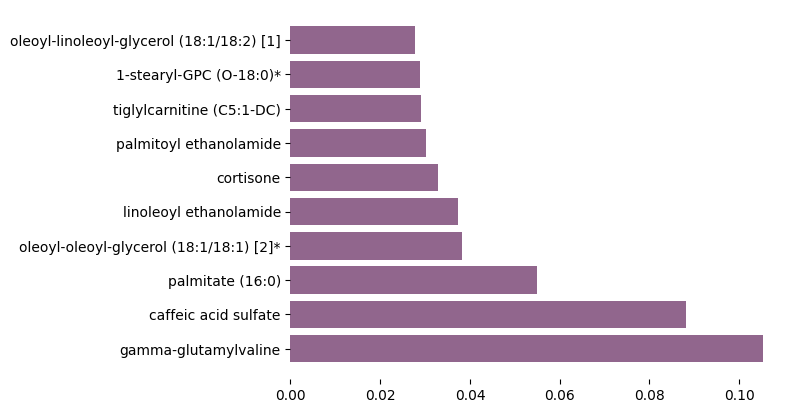

BIOCHEMICAL  PATHWAY_SORTORDER  \
37                                   cortisone             3335.0   
65                            palmitate (16:0)             1528.0   
168                     palmitoyl ethanolamide             2180.0   
280                       gamma-glutamylvaline              663.0   
388                  tiglylcarnitine (C5:1-DC)              405.0   
509  oleoyl-linoleoyl-glycerol (18:1/18:2) [1]             2945.0   
629                     linoleoyl ethanolamide             2200.0   
692                    1-stearyl-GPC (O-18:0)*             2850.0   
710                       caffeic acid sulfate             5226.0   
722    oleoyl-oleoyl-glycerol (18:1/18:1) [2]*             2943.0   

    SUPER_PATHWAY                                SUB_PATHWAY  COMP_ID  \
37          Lipid                            Corticosteroids     1769   
65          Lipid            Long Chain Saturated Fatty Acid     1336   
168         Lipid                            Endocannabinoid    38165   
280       Peptide                  Gamma-glutamyl Amino Acid    43829   
388    Amino Acid  Leucine, Isoleucine and Valine Metabolism    35428   
509         Lipid                             Diacylglycerol    46798   
629         Lipid                            Endocannabinoid    52608   
692         Lipid                            Lysoplasmalogen    52703   
710   Xenobiotics                       Food Component/Plant    53254   
722         Lipid                             Diacylglycerol    54946   

      PLATFORM  CHEMICAL_ID   PUBCHEM          CAS    KEGG      HMDB_ID  
37         Neg          273    222786      53-06-5  C00762  HMDB0002802  
65         Neg          424       985      57-10-3  C00249  HMDB0000220  
168        Neg         1489      4671     544-31-0  C16512  HMDB0002100  
280  Pos Early    100001126   7015683    2746-34-1     NaN  HMDB0011172  
388  Pos Early    100001597  22833596   64191-86-2     NaN  HMDB0002366  
509   Pos Late    100002989  14275396  106292-55-1     NaN  HMDB0007219  
629        Neg    100006726   5283446   68171-52-8     NaN  HMDB0012252  
692   Pos Late    100009147   2733532          NaN  C04317  HMDB0011149  
710      Polar    100009337  21668705          NaN     NaN  HMDB0041708  
722   Pos Late    100010919   9543716          NaN     NaN  HMDB0007218

In [26]:
top_k_importances(model_kbest, 10)

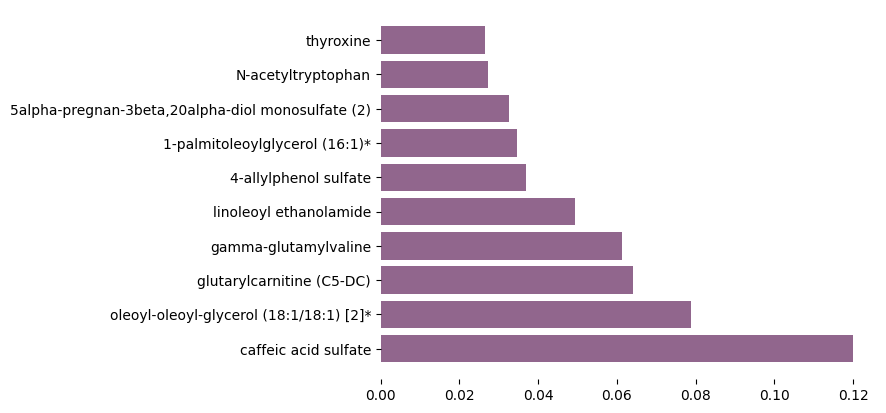

BIOCHEMICAL  PATHWAY_SORTORDER  \
139                                          thyroxine              250.0   
280                               gamma-glutamylvaline              663.0   
303                                 N-acetyltryptophan              260.0   
386                          glutarylcarnitine (C5-DC)              129.0   
429                              4-allylphenol sulfate             5111.0   
451  5alpha-pregnan-3beta,20alpha-diol monosulfate (2)             3294.0   
629                             linoleoyl ethanolamide             2200.0   
640                     1-palmitoleoylglycerol (16:1)*             2871.0   
710                               caffeic acid sulfate             5226.0   
722            oleoyl-oleoyl-glycerol (18:1/18:1) [2]*             2943.0   

    SUPER_PATHWAY                SUB_PATHWAY  COMP_ID   PLATFORM  CHEMICAL_ID  \
139    Amino Acid        Tyrosine Metabolism     2761        Neg         1094   
280       Peptide  Gamma-glutamyl Amino Acid    43829  Pos Early    100001126   
303    Amino Acid      Tryptophan Metabolism    33959        Neg    100001254   
386    Amino Acid          Lysine Metabolism    44664  Pos Early    100001593   
429   Xenobiotics       Food Component/Plant    37181        Neg    100001868   
451         Lipid         Progestin Steroids    37200        Neg    100002014   
629         Lipid            Endocannabinoid    52608        Neg    100006726   
640         Lipid           Monoacylglycerol    52431        Neg    100008952   
710   Xenobiotics       Food Component/Plant    53254      Polar    100009337   
722         Lipid             Diacylglycerol    54946   Pos Late    100010919   

           PUBCHEM          CAS    KEGG      HMDB_ID  
139           5819      51-48-9  C01829  HMDB0000248  
280        7015683    2746-34-1     NaN  HMDB0011172  
303  439917,700653    1218-34-4  C03137  HMDB0013713  
386       71317118  102636-82-8     NaN  HMDB0013130  
429       66633409          NaN     NaN          NaN  
451            NaN          NaN     NaN          NaN  
629        5283446   68171-52-8     NaN  HMDB0012252  
640            NaN          NaN     NaN  HMDB0011565  
710       21668705          NaN     NaN  HMDB0041708  
722        9543716          NaN     NaN  HMDB0007218

In [27]:
top_k_importances(model_mrmr, 10)

### Patients dataset:

File **sampleAttr.csv** contains information on patients from 4 clinical studies. 

Loading dataset, fixing format and adding BMI column:

In [28]:
clin_df = pd.read_csv("./metabolomics/sampleAttr.csv")
clin_df['age'] = [float(x.replace(',', '.')) for x in clin_df['age']]
clin_df['weight'] = [float(x.replace(',', '.')) for x in clin_df['weight']]
clin_df['height'] = [float(x.replace(',', '.')) for x in clin_df['height']]
clin_df['smoking'] = [1 if x == 'Smoker' or x == '1' else 0 for x in clin_df.smoking]
clin_df['BMI'] = clin_df['weight'] / (clin_df['height'] / 100)**2

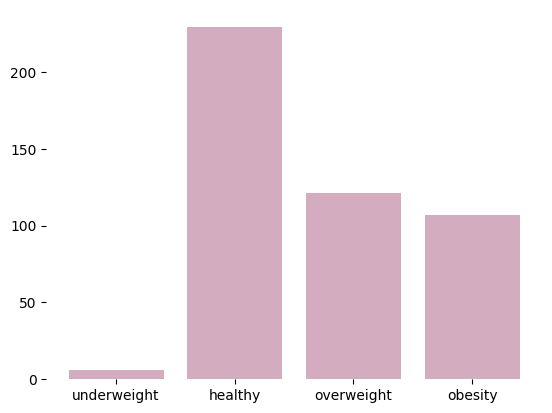

In [29]:
bmi = [clin_df[clin_df['BMI'] < 18.5].shape[0], 
 clin_df[clin_df['BMI'] < 25.0].shape[0] - clin_df[clin_df['BMI'] < 18.5].shape[0], 
 clin_df[clin_df['BMI'] >= 25].shape[0] - clin_df[clin_df['BMI'] >= 30].shape[0],
 clin_df[clin_df['BMI'] >= 30].shape[0]]

plt.bar(range(4), bmi, color='#d3adbf')
plt.xticks(range(4), ['underweight', 'healthy', 'overweight', 'obesity'])
# plt.title('BMI')
plt.box(False)
plt.show()

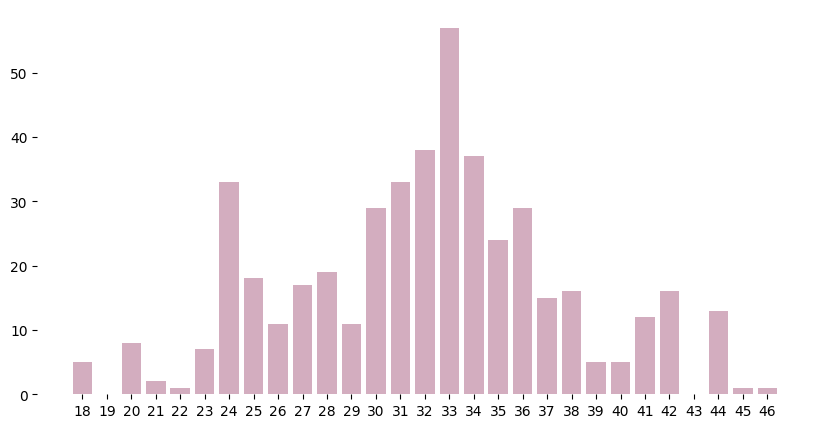

In [30]:
age = np.rint(clin_df.age).sort_values()

plt.figure(figsize=(10, 5))
plt.bar(range(18, 47), np.bincount(age)[18:], color='#d3adbf')
plt.xticks(range(18, 47))
# plt.title('Age')
plt.box(False)
plt.show()

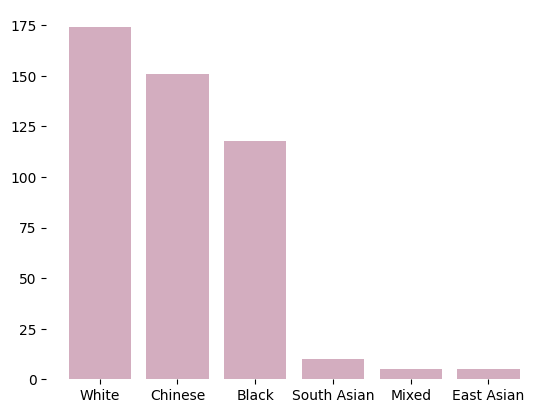

In [31]:
race = clin_df.race.value_counts()

plt.bar(range(race.shape[0]), race, color='#d3adbf')
plt.xticks(range(race.shape[0]), labels=race.index)
# plt.title('Race')
plt.box(False)
plt.show()

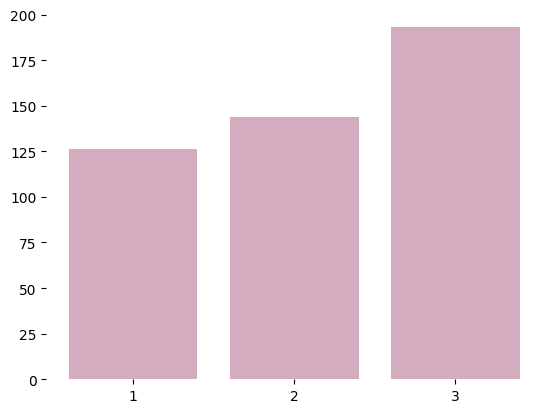

In [32]:
trimester = clin_df.trimester.value_counts().sort_index()
plt.bar(range(trimester.shape[0]), trimester, color='#d3adbf')
plt.xticks(range(trimester.shape[0]), labels=trimester.index)
# plt.title('Trimester')
plt.box(False)
plt.show()

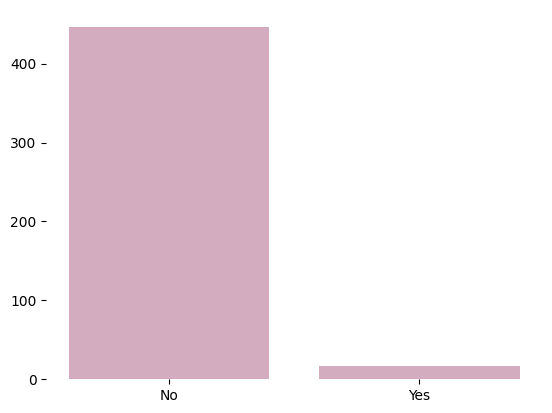

In [33]:
plt.bar([0, 1], np.bincount(clin_df.smoking), color='#d3adbf')
plt.xticks([0, 1], ['No', 'Yes'])
# plt.title('Smoking')
plt.box(False)
plt.show()

## Statistical tests

In [34]:
from scipy import stats

In [35]:
# get feature importances from xgb
def feature_importances(model):
    return sorted(zip(model.steps[0][1].solution, model.steps[2][1].feature_importances_), key= lambda x: x[1], reverse=True)

# apply statistics test, groups divided by preeclampsy indicator -> returns statisticaly important features
def statistics_test(test_type):
    stat_important_features = []
    test_df = clin_df[['trimester', 'sIDs', 'pe']].join(X, on='sIDs', how='right')
    group1 = test_df[test_df.pe == 1]
    group2 = test_df[test_df.pe == 0]
    
    for metabolite in X.columns:
        t_stat, p_value = test_type(group1[metabolite], group2[metabolite])
        if p_value < 0.05:
            stat_important_features.append(metabolite)

    return stat_important_features

# intersection for both sets of impotrant features with xgb rank and importance value
def find_important_features(model, test_type):
    model_importances = feature_importances(model)
    stat_importances = statistics_test(test_type)
    
    importance_dict = {}
    v = [x[0] for x in model_importances]
    for m in stat_importances:
        if m in v:
            importance_dict[m] = (v.index(m), model_importances[v.index(m)][1])
        
    return importance_dict

In [36]:
importances_kbest = find_important_features(model_kbest, stats.mannwhitneyu)
importances_mrmr = find_important_features(model_mrmr, stats.mannwhitneyu)

In [37]:
importances_kbest

{1769: (5, 0.032883957),
 1336: (2, 0.054888118),
 57: (29, 0.014558687),
 1494: (11, 0.026539711),
 38102: (24, 0.017041396),
 38165: (6, 0.030250438),
 19263: (28, 0.015049545),
 32391: (32, 0.013113755),
 43829: (0, 0.10526719),
 32417: (34, 0.012251791),
 33959: (20, 0.019480206),
 33950: (36, 0.010122123),
 48351: (37, 0.0070907013),
 34456: (27, 0.015140742),
 35428: (7, 0.029047098),
 57591: (13, 0.025722358),
 37200: (21, 0.018982857),
 37184: (14, 0.02562567),
 32827: (16, 0.024819074),
 39609: (39, 0.0062153805),
 46798: (9, 0.027725685),
 46799: (18, 0.023190739),
 40008: (33, 0.01239862),
 40708: (22, 0.017988939),
 42459: (26, 0.01575),
 48457: (19, 0.021679953),
 52988: (25, 0.016435383),
 52608: (4, 0.03739259),
 52431: (23, 0.01778496),
 52464: (17, 0.024802618),
 53254: (1, 0.08820528),
 54942: (15, 0.025353316),
 54945: (38, 0.0069432473),
 54946: (3, 0.03817017),
 57637: (35, 0.01172933),
 62059: (30, 0.01450373)}

In [38]:
importances_mrmr

{1769: (13, 0.025312817),
 2761: (9, 0.026600763),
 15122: (25, 0.013576799),
 15500: (31, 0.009832224),
 21025: (17, 0.022965258),
 27710: (15, 0.024633491),
 32391: (26, 0.0135090295),
 43829: (3, 0.0612655),
 32417: (33, 0.008650918),
 33959: (8, 0.02732511),
 45095: (37, 0.0058471523),
 44664: (2, 0.064151056),
 36098: (19, 0.020913301),
 37181: (5, 0.036944672),
 57591: (27, 0.013195406),
 37200: (7, 0.03254474),
 37184: (10, 0.026597446),
 32827: (22, 0.018253056),
 40008: (16, 0.02300511),
 40708: (21, 0.018344872),
 42459: (29, 0.010797676),
 37185: (14, 0.02521834),
 48457: (30, 0.010306564),
 52988: (34, 0.007424278),
 52608: (4, 0.04937222),
 52431: (6, 0.034488257),
 52465: (39, 0.0024993387),
 52500: (12, 0.025515847),
 53254: (0, 0.11996918),
 54946: (1, 0.07874481),
 57637: (28, 0.013154269),
 62059: (35, 0.007288444)}

In [75]:
# T test -> Assumptions of normal distribution
# Shapiro test -> test for normal distribution in data (0-hypothesis: data is not from normal distribution)

In [76]:
def check_normal_distribution():
    normal = []
    for metabolite in X.columns:
        s, p = stats.shapiro(X[metabolite])
        if p > 0.05:
            normal.append(metabolite)
            
    return normal

In [77]:
normal_distr_features = check_normal_distribution()

In [78]:
test_df = clin_df[['trimester', 'sIDs', 'pe']].join(X[normal_distr_features], on='sIDs', how='right')
group1 = test_df[test_df.pe == 1]
group2 = test_df[test_df.pe == 0]

t_test_res = []
for m in normal_distr_features:
    t, p = stats.ttest_ind(group1[m], group2[m])
    if p < 0.05:
        t_test_res.append(m)

In [79]:
t_test_res

[1769, 54, 15506, 52461, 42459, 52500]

In [80]:
proba = feature_importances(model_mrmr)
proba = [x[0] for x in proba]
res = []
for m in t_test_res:
    if m in proba:
        res.append(m)

In [81]:
comp_df[comp_df.COMP_ID.isin(res)]

BIOCHEMICAL  PATHWAY_SORTORDER  \
37                                  cortisone             3335.0   
544   sphingomyelin (d18:2/16:0, d18:1/16:1)*             3137.0   
673  1-margaroyl-2-linoleoyl-GPC (17:0/18:2)*             2335.0   

    SUPER_PATHWAY               SUB_PATHWAY  COMP_ID  PLATFORM  CHEMICAL_ID  \
37          Lipid           Corticosteroids     1769       Neg          273   
544         Lipid            Sphingomyelins    42459  Pos Late    100004329   
673         Lipid  Phosphatidylcholine (PC)    52500  Pos Late    100009037   

      PUBCHEM      CAS    KEGG                  HMDB_ID  
37     222786  53-06-5  C00762              HMDB0002802  
544       NaN      NaN     NaN  HMDB0240638,HMDB0240613  
673  52922491      NaN     NaN                      NaN

### plot all statisticaly important features, ranked by feature importance

In [39]:
comp_df = pd.read_csv('metabolomics/compAnno.csv')

In [40]:
def plt_importances(importances):
    plt.figure(figsize=(5, 10))
    
    importances = sorted(importances.items(), key = lambda x: x[1][0])
    values = [x[1][1] for x in importances]
    labels = [x[0] for x in importances]
    names = [comp_df[comp_df.COMP_ID == x].BIOCHEMICAL.item() for x in labels]
    
#     plt.title('Feature importance')
    plt.barh(range(len(importances)), values, color='#91668d')
    plt.yticks(range(len(importances)), labels=names)
    plt.box(False)
    plt.show()

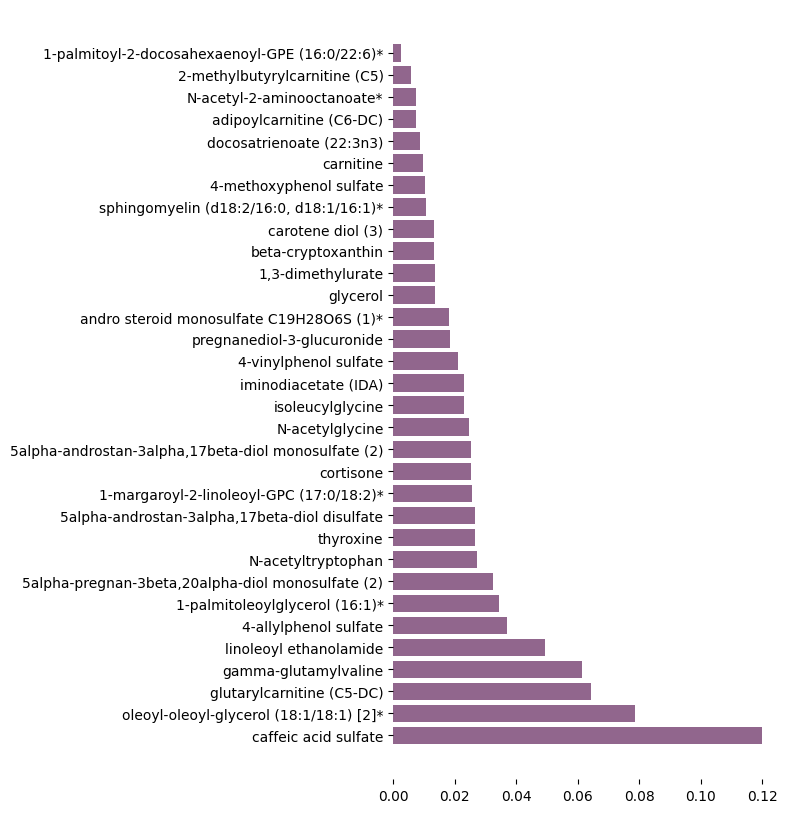

In [41]:
plt_importances(importances_mrmr)

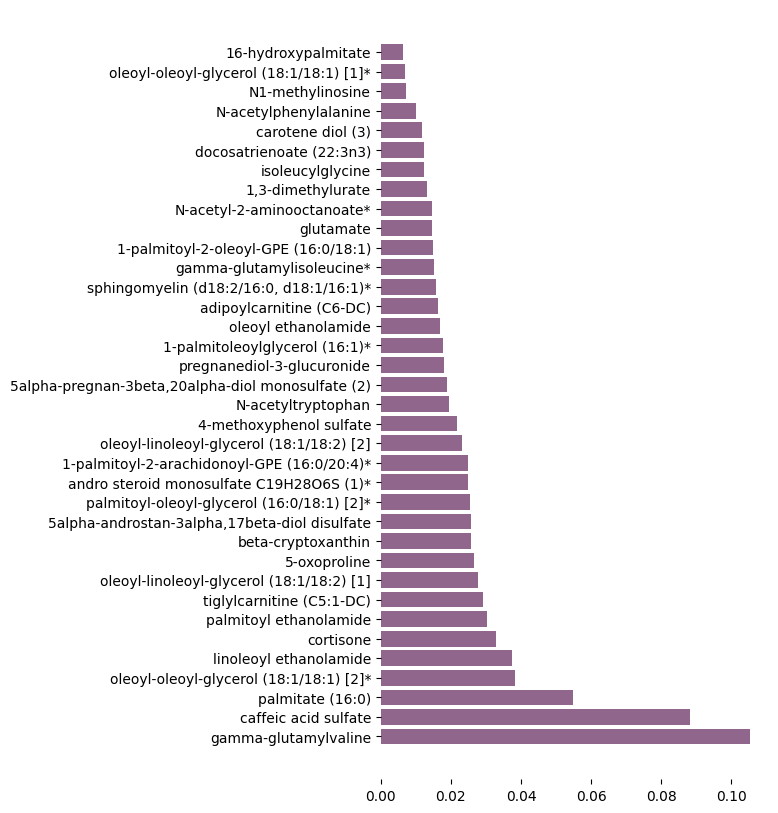

In [42]:
plt_importances(importances_kbest)

In [43]:
len(importances_mrmr)

32

In [44]:
len(importances_kbest)

36

In [45]:
# important metabolites information
comp_df = pd.read_csv('./metabolomics/compAnno.csv')
comp_df[comp_df.COMP_ID.isin(importances_kbest.keys())]

BIOCHEMICAL  PATHWAY_SORTORDER  \
37                                           cortisone             3335.0   
65                                    palmitate (16:0)             1528.0   
88                                           glutamate               46.0   
126                                       5-oxoproline              587.0   
152                                oleoyl ethanolamide             2177.0   
168                             palmitoyl ethanolamide             2180.0   
170               1-palmitoyl-2-oleoyl-GPE (16:0/18:1)             2426.0   
276                                  1,3-dimethylurate             4618.0   
280                               gamma-glutamylvaline              663.0   
291                           docosatrienoate (22:3n3)             1582.0   
303                                 N-acetyltryptophan              260.0   
304                              N-acetylphenylalanine              144.0   
347                                   N1-methylinosine             4146.0   
364                          gamma-glutamylisoleucine*              654.0   
388                          tiglylcarnitine (C5:1-DC)              405.0   
438                                 beta-cryptoxanthin             4456.0   
451  5alpha-pregnan-3beta,20alpha-diol monosulfate (2)             3294.0   
453      5alpha-androstan-3alpha,17beta-diol disulfate             3400.0   
471           andro steroid monosulfate C19H28O6S (1)*             3413.0   
508                                16-hydroxypalmitate             2028.0   
509          oleoyl-linoleoyl-glycerol (18:1/18:2) [1]             2945.0   
510          oleoyl-linoleoyl-glycerol (18:1/18:2) [2]             2946.0   
516                                   isoleucylglycine              869.0   
524                         pregnanediol-3-glucuronide             3303.0   
544            sphingomyelin (d18:2/16:0, d18:1/16:1)*             3137.0   
603                            4-methoxyphenol sulfate              198.0   
625                           adipoylcarnitine (C6-DC)             1925.0   
629                             linoleoyl ethanolamide             2200.0   
640                     1-palmitoleoylglycerol (16:1)*             2871.0   
650        1-palmitoyl-2-arachidonoyl-GPE (16:0/20:4)*             2434.0   
710                               caffeic acid sulfate             5226.0   
720         palmitoyl-oleoyl-glycerol (16:0/18:1) [2]*             2924.0   
721            oleoyl-oleoyl-glycerol (18:1/18:1) [1]*             2942.0   
722            oleoyl-oleoyl-glycerol (18:1/18:1) [2]*             2943.0   
770                                  carotene diol (3)             4454.0   
788                         N-acetyl-2-aminooctanoate*             1774.0   

              SUPER_PATHWAY  \
37                    Lipid   
65                    Lipid   
88               Amino Acid   
126              Amino Acid   
152                   Lipid   
168                   Lipid   
170                   Lipid   
276             Xenobiotics   
280                 Peptide   
291                   Lipid   
303              Amino Acid   
304              Amino Acid   
347              Nucleotide   
364                 Peptide   
388              Amino Acid   
438  Cofactors and Vitamins   
451                   Lipid   
453                   Lipid   
471                   Lipid   
508                   Lipid   
509                   Lipid   
510                   Lipid   
516                 Peptide   
524                   Lipid   
544                   Lipid   
603              Amino Acid   
625                   Lipid   
629                   Lipid   
640                   Lipid   
650                   Lipid   
710             Xenobiotics   
720                   Lipid   
721                   Lipid   
722                   Lipid   
770  Cofactors and Vitamins   
788                   Lipid   

                                           SU

Data projection on most important features

In [47]:
X, y = data_load_preprocess()

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/home/lucija/.local/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


In [48]:
X_proj = X[importances_mrmr.keys()]

In [49]:
import umap.umap_ as umap
import seaborn as sns

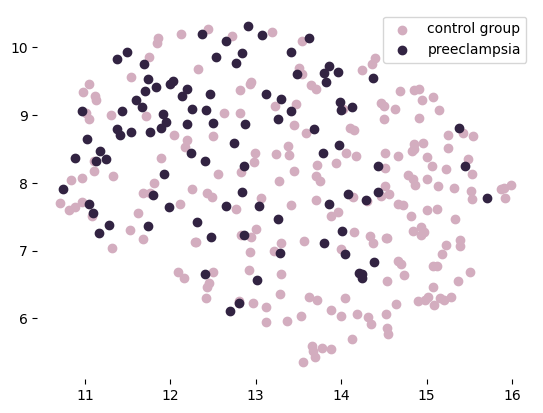

In [50]:
import umap.umap_ as umap
import seaborn as sns
umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(X_proj)

df_umap = pd.DataFrame(umap_result)
df_umap['pe'] = np.array(y)
plt.scatter(df_umap[df_umap.pe == 0][0], df_umap[df_umap.pe == 0][1], color='#d3adbf')
plt.scatter(df_umap[df_umap.pe == 1][0], df_umap[df_umap.pe == 1][1], color='#322342')
plt.legend(['control group', 'preeclampsia'])
plt.box(False)
plt.show()

In [51]:
from sklearn.decomposition import PCA

In [52]:
pca = PCA(n_components=2)

In [53]:
X_proj_pca = pca.fit_transform(X_proj)

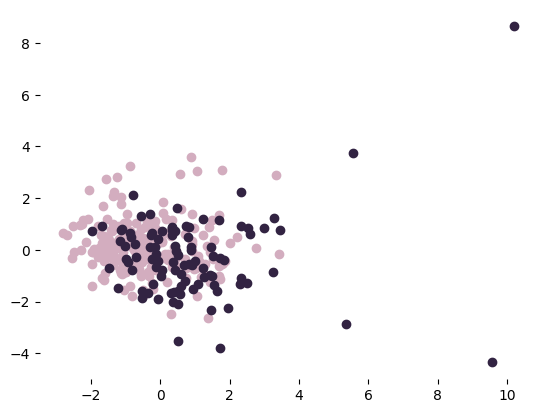

In [54]:
df_pca = pd.DataFrame(X_proj_pca)
df_pca['pe'] = np.array(y)
plt.scatter(df_pca[df_pca.pe == 0][0], df_pca[df_pca.pe == 0][1], color='#d3adbf')
plt.scatter(df_pca[df_pca.pe == 1][0], df_pca[df_pca.pe == 1][1], color='#322342')
plt.box(False)
plt.show()

Intersect of two sets of important features

In [55]:
comp_df[comp_df.COMP_ID.isin(importances_mrmr.keys())]

BIOCHEMICAL  PATHWAY_SORTORDER  \
37                                           cortisone             3335.0   
139                                          thyroxine              250.0   
162                                           glycerol             2860.0   
186                                          carnitine             1950.0   
249                               iminodiacetate (IDA)             6195.0   
259                                    N-acetylglycine                2.0   
276                                  1,3-dimethylurate             4618.0   
280                               gamma-glutamylvaline              663.0   
291                           docosatrienoate (22:3n3)             1582.0   
303                                 N-acetyltryptophan              260.0   
366                      2-methylbutyrylcarnitine (C5)              402.0   
386                          glutarylcarnitine (C5-DC)              129.0   
412                              4-vinylphenol sulfate             4547.0   
429                              4-allylphenol sulfate             5111.0   
438                                 beta-cryptoxanthin             4456.0   
451  5alpha-pregnan-3beta,20alpha-diol monosulfate (2)             3294.0   
453      5alpha-androstan-3alpha,17beta-diol disulfate             3400.0   
471           andro steroid monosulfate C19H28O6S (1)*             3413.0   
516                                   isoleucylglycine              869.0   
524                         pregnanediol-3-glucuronide             3303.0   
544            sphingomyelin (d18:2/16:0, d18:1/16:1)*             3137.0   
581  5alpha-androstan-3alpha,17beta-diol monosulfat...             3399.0   
603                            4-methoxyphenol sulfate              198.0   
625                           adipoylcarnitine (C6-DC)             1925.0   
629                             linoleoyl ethanolamide             2200.0   
640                     1-palmitoleoylglycerol (16:1)*             2871.0   
651     1-palmitoyl-2-docosahexaenoyl-GPE (16:0/22:6)*             2436.0   
673           1-margaroyl-2-linoleoyl-GPC (17:0/18:2)*             2335.0   
710                               caffeic acid sulfate             5226.0   
722            oleoyl-oleoyl-glycerol (18:1/18:1) [2]*             2943.0   
770                                  carotene diol (3)             4454.0   
788                         N-acetyl-2-aminooctanoate*             1774.0   

              SUPER_PATHWAY  \
37                    Lipid   
139              Amino Acid   
162                   Lipid   
186                   Lipid   
249             Xenobiotics   
259              Amino Acid   
276             Xenobiotics   
280                 Peptide   
291                   Lipid   
303              Amino Acid   
366              Amino Acid   
386              Amino Acid   
412             Xenobiotics   
429             Xenobiotics   
438  Cofactors and Vitamins   
451                   Lipid   
453                   Lipid   
471                   Lipid   
516                 Peptide   
524                   Lipid   
544                   Lipid   
581                   Lipid   
603              Amino Acid   
625                   Lipid   
629                   Lipid   
640                   Lipid   
651                   Lipid   
673                   Lipid   
710             Xenobiotics   
722                   Lipid   
770  Cofactors and Vitamins   
788                   Lipid   

                                           SUB_PATHWAY  COMP_ID   PLATFORM  \
37                                     Corticosteroids     1769        Neg   
139                                Tyrosine Metabolism     2761        Neg   
162                            Glycerolipid Metabolism    15122        Neg   
186                               Carnitine Metabolism    15500  Pos Early   
249                                           Chemical    21025  Pos Early   
259      

In [56]:
importances_intersect = [x for x in importances_kbest.keys() if x in importances_mrmr.keys()]

In [57]:
comp_df[comp_df.COMP_ID.isin(importances_intersect)]

BIOCHEMICAL  PATHWAY_SORTORDER  \
37                                           cortisone             3335.0   
276                                  1,3-dimethylurate             4618.0   
280                               gamma-glutamylvaline              663.0   
291                           docosatrienoate (22:3n3)             1582.0   
303                                 N-acetyltryptophan              260.0   
438                                 beta-cryptoxanthin             4456.0   
451  5alpha-pregnan-3beta,20alpha-diol monosulfate (2)             3294.0   
453      5alpha-androstan-3alpha,17beta-diol disulfate             3400.0   
471           andro steroid monosulfate C19H28O6S (1)*             3413.0   
516                                   isoleucylglycine              869.0   
524                         pregnanediol-3-glucuronide             3303.0   
544            sphingomyelin (d18:2/16:0, d18:1/16:1)*             3137.0   
603                            4-methoxyphenol sulfate              198.0   
625                           adipoylcarnitine (C6-DC)             1925.0   
629                             linoleoyl ethanolamide             2200.0   
640                     1-palmitoleoylglycerol (16:1)*             2871.0   
710                               caffeic acid sulfate             5226.0   
722            oleoyl-oleoyl-glycerol (18:1/18:1) [2]*             2943.0   
770                                  carotene diol (3)             4454.0   
788                         N-acetyl-2-aminooctanoate*             1774.0   

              SUPER_PATHWAY  \
37                    Lipid   
276             Xenobiotics   
280                 Peptide   
291                   Lipid   
303              Amino Acid   
438  Cofactors and Vitamins   
451                   Lipid   
453                   Lipid   
471                   Lipid   
516                 Peptide   
524                   Lipid   
544                   Lipid   
603              Amino Acid   
625                   Lipid   
629                   Lipid   
640                   Lipid   
710             Xenobiotics   
722                   Lipid   
770  Cofactors and Vitamins   
788                   Lipid   

                                           SUB_PATHWAY  COMP_ID   PLATFORM  \
37                                     Corticosteroids     1769        Neg   
276                                Xanthine Metabolism    32391        Neg   
280                          Gamma-glutamyl Amino Acid    43829  Pos Early   
291  Long Chain Polyunsaturated Fatty Acid (n3 and n6)    32417        Neg   
303                              Tryptophan Metabolism    33959        Neg   
438                               Vitamin A Metabolism    57591   Pos Late   
451                                 Progestin Steroids    37200        Neg   
453                                Androgenic Steroids    37184        Neg   
471                                Androgenic Steroids    32827        Neg   
516                                          Dipeptide    40008        Neg   
524                                 Progestin Steroids    40708        Neg   
544                                     Sphingomyelins    42459   Pos Late   
603                                Tyrosine Metabolism    48457        Neg   
625  Fatty Acid Metabolism (Acyl Carnitine, Dicarbo...    52988  Pos Early   
629                                    Endocannabinoid    52608        Neg   
640                                   Monoacylglycerol    52431        Neg   
710                               Food Component/Plant    53254      Polar   
722                                     Diacylglycerol    54946   Pos Late   
770                               Vitamin A Metabolism    57637   Pos Late   
788                                  Fatty Acid, Amino    62059        Neg   

     CHEMICAL_ID        PUBCHEM         CAS    KEGG                  HMDB_ID  
37           273         222786     53-06-5  C00762    

### Metabolites concentration change through trimesters

In [58]:
test = clin_df[['trimester', 'sIDs', 'pe']].join(X[importances_mrmr.keys()], on='sIDs', how='right')
group0 = test[test.pe == 0].drop('pe', axis = 1).groupby('trimester')
group1 = test[test.pe == 1].drop('pe', axis = 1).groupby('trimester')

In [59]:
importances_mrmr = dict(sorted(importances_mrmr.items(), key= lambda x: x[1]))

In [60]:
importances_mrmr

{53254: (0, 0.11996918),
 54946: (1, 0.07874481),
 44664: (2, 0.064151056),
 43829: (3, 0.0612655),
 52608: (4, 0.04937222),
 37181: (5, 0.036944672),
 52431: (6, 0.034488257),
 37200: (7, 0.03254474),
 33959: (8, 0.02732511),
 2761: (9, 0.026600763),
 37184: (10, 0.026597446),
 52500: (12, 0.025515847),
 1769: (13, 0.025312817),
 37185: (14, 0.02521834),
 27710: (15, 0.024633491),
 40008: (16, 0.02300511),
 21025: (17, 0.022965258),
 36098: (19, 0.020913301),
 40708: (21, 0.018344872),
 32827: (22, 0.018253056),
 15122: (25, 0.013576799),
 32391: (26, 0.0135090295),
 57591: (27, 0.013195406),
 57637: (28, 0.013154269),
 42459: (29, 0.010797676),
 48457: (30, 0.010306564),
 15500: (31, 0.009832224),
 32417: (33, 0.008650918),
 52988: (34, 0.007424278),
 62059: (35, 0.007288444),
 45095: (37, 0.0058471523),
 52465: (39, 0.0024993387)}

In [61]:
group0.agg(['mean', 'median', 'std'])

1769                          2761                       \
               mean    median       std      mean    median       std   
trimester                                                               
1         -0.108232 -0.151124  0.499618  0.114192  0.127919  0.573469   
2          0.206447  0.159592  0.581871  0.205141  0.256389  0.535350   
3          0.380863  0.443684  0.572690  0.257088  0.121604  0.760339   

              15122                         15500  ...     53254     54946  \
               mean    median       std      mean  ...       std      mean   
trimester                                          ...                       
1          0.388723  0.258353  1.042431  0.142301  ...  0.433021  0.193010   
2         -0.200546 -0.168593  0.705287 -0.704627  ...  0.432116  0.347969   
3         -0.146564 -0.298444  0.813180 -0.659660  ...  0.478435  0.365149   

                                  57637                         62059  \
             median       std      mean    median       std      mean   
trimester                                                               
1          0.236927  0.428745 -0.172301 -0.224790  0.623480 -0.354367   
2          0.392413  0.537030  0.158594  0.114302  0.652535 -0.358735   
3          0.198373  0.656926  0.181032  0.145164  0.747258 -0.406736   

                               
             median       std  
trimester                      
1         -0.490018  0.856774  
2         -0.468768  0.638171  
3         -0.593990  0.761087  

[3 rows x 96 columns]

In [62]:
group1.agg(['mean', 'median', 'std'])

1769                          2761                       \
               mean    median       std      mean    median       std   
trimester                                                               
1          0.392667  0.571275  0.917684  0.241592  0.154482  0.468755   
2          0.402860  0.468222  0.900877  0.036704  0.020787  0.515688   
3          0.549183  0.399884  0.649591 -0.076788 -0.112596  0.922721   

              15122                         15500  ...     53254     54946  \
               mean    median       std      mean  ...       std      mean   
trimester                                          ...                       
1          0.566551  0.673350  0.843226 -0.322886  ...  0.517979  0.275505   
2         -0.253964 -0.068367  1.064878 -0.996119  ...  0.495024  0.739507   
3          0.488393  0.164556  1.285349 -0.673126  ...  0.289894  0.563951   

                                  57637                         62059  \
             median       std      mean    median       std      mean   
trimester                                                               
1          0.476430  0.711829 -0.198752 -0.288062  0.788259 -0.576659   
2          0.696434  0.524456 -0.010423  0.069487  0.835329 -0.688180   
3          0.022816  0.805445 -0.236334 -0.394863  0.764203 -0.588882   

                               
             median       std  
trimester                      
1         -0.575997  0.315418  
2         -0.629995  0.437280  
3         -0.672809  0.542294  

[3 rows x 96 columns]

In [63]:
mean_values0 = group0.agg('mean')
mean_values1 = group1.agg('mean')

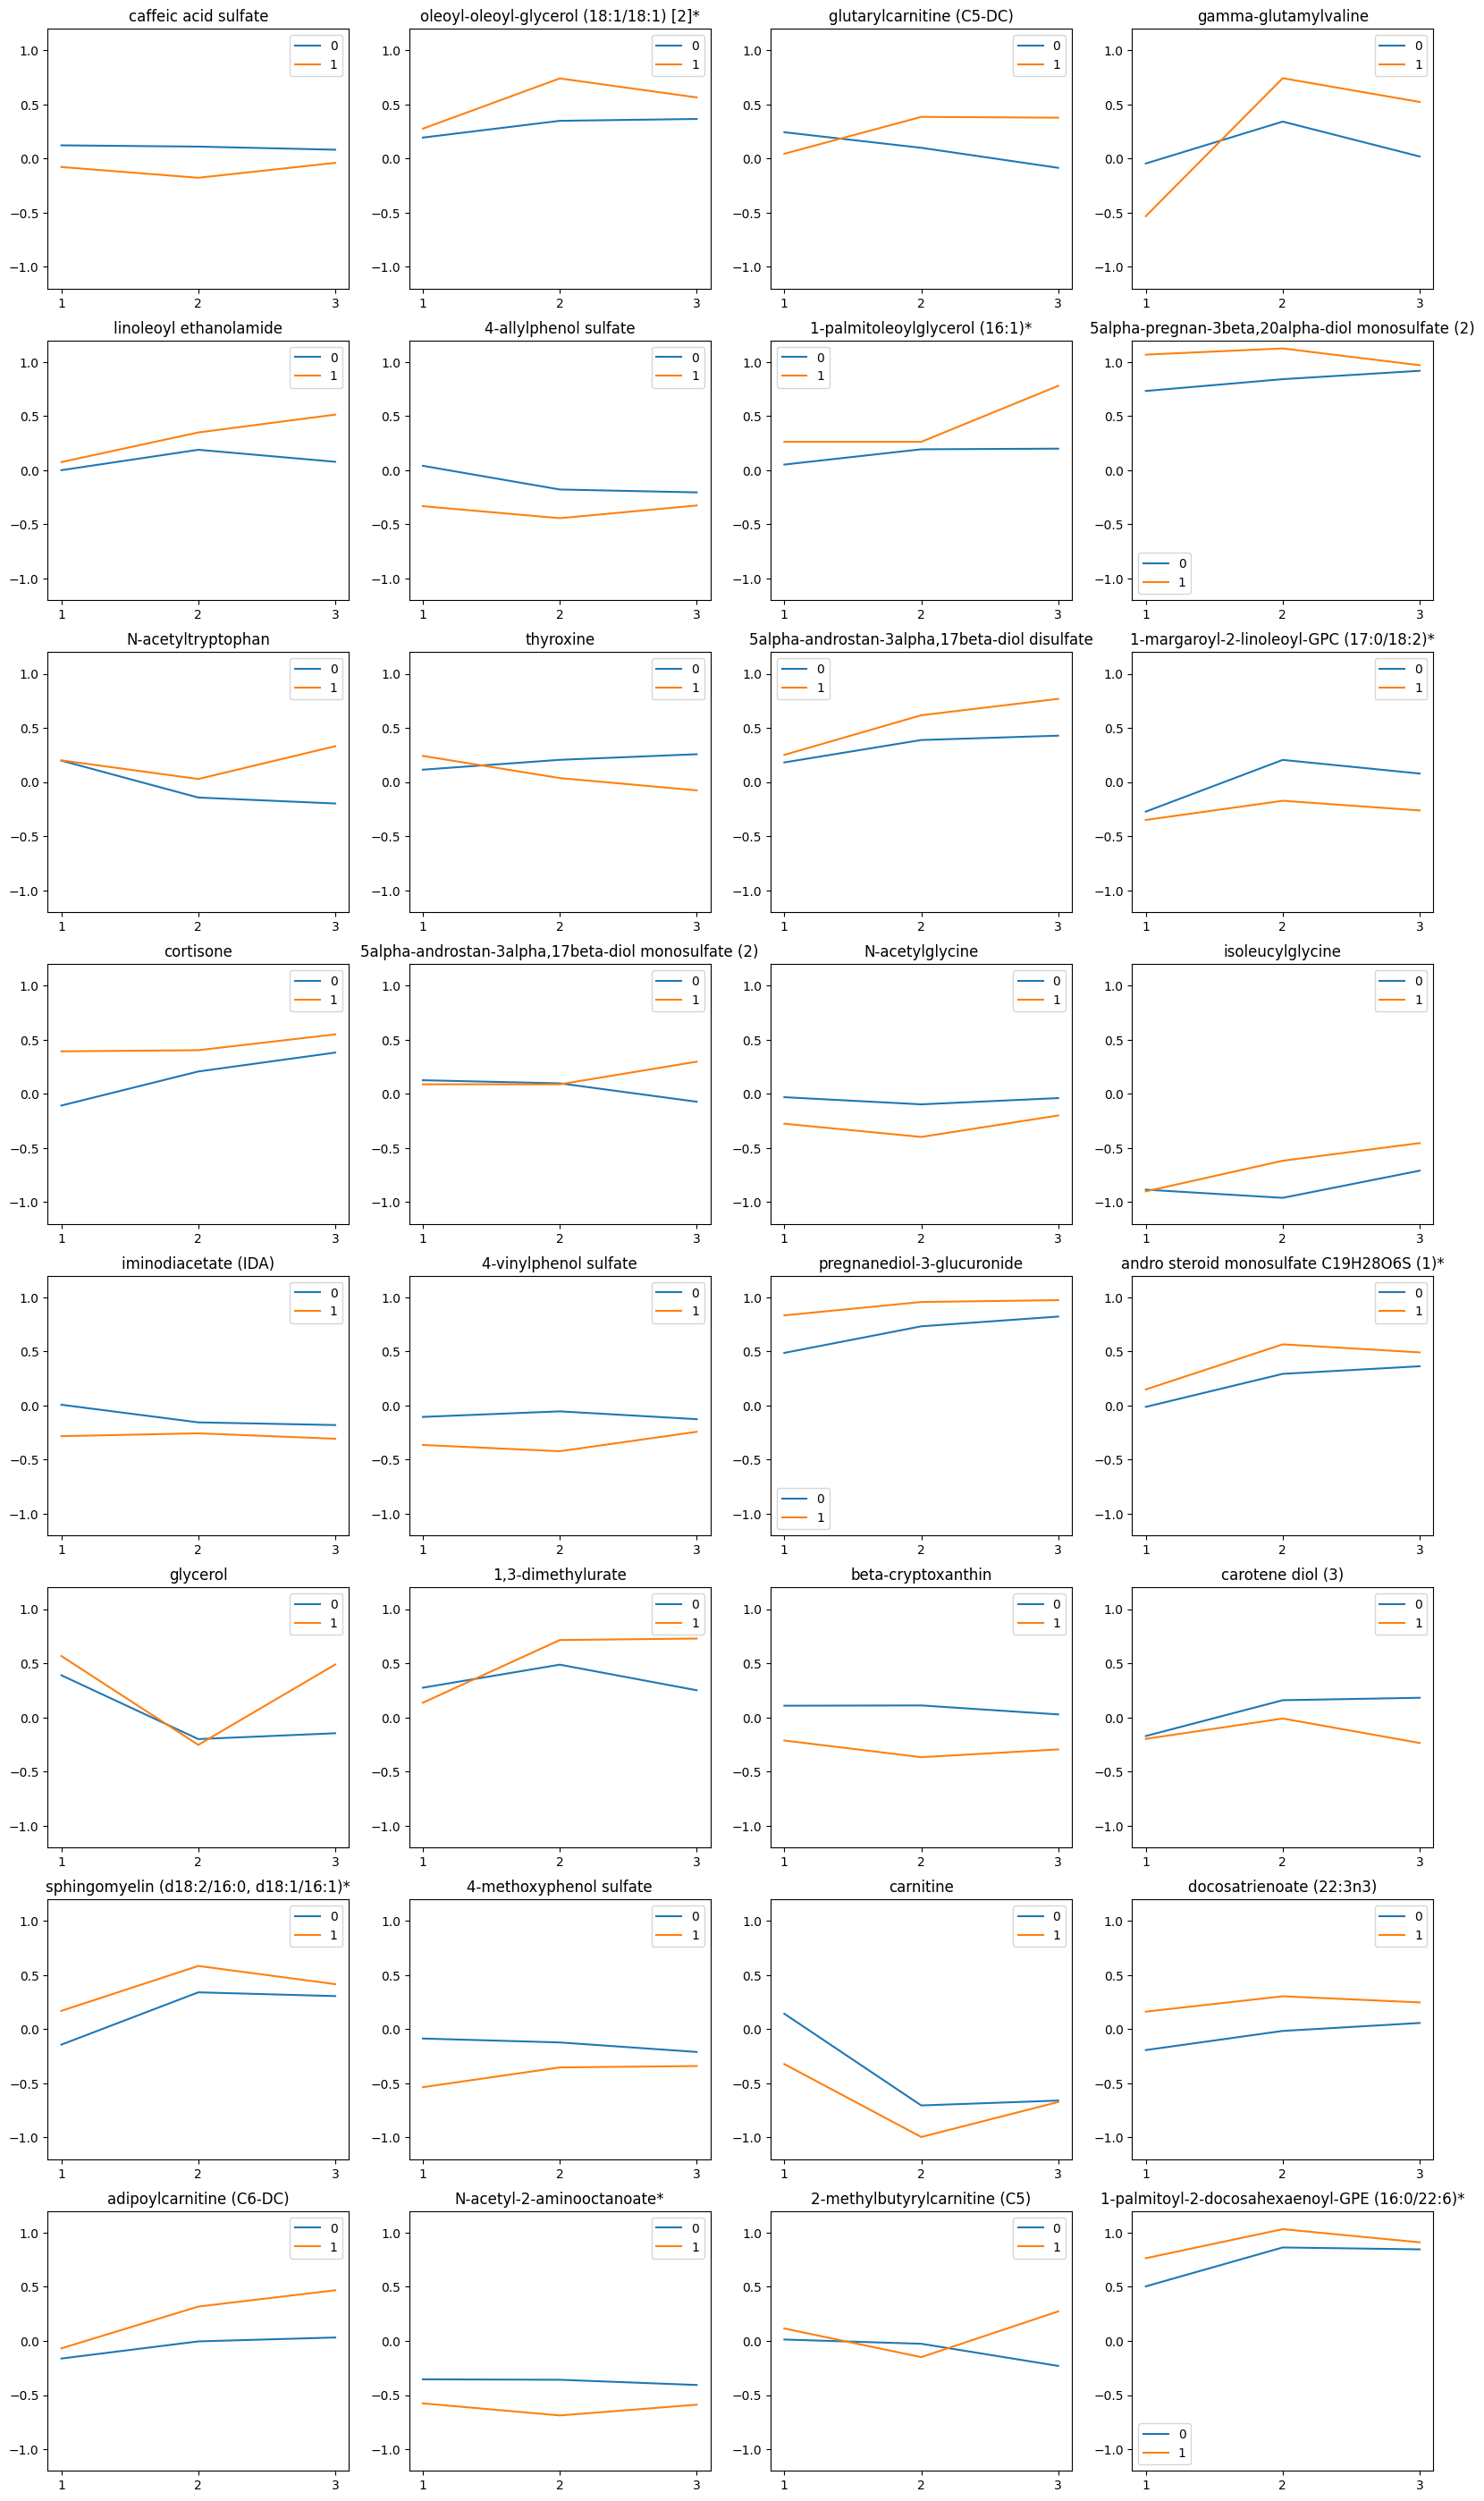

In [64]:
# plot change through trimesters
i = 1
plt.figure(figsize=(20, 40))
for m in importances_mrmr.keys():
    plt.subplot(9, 4, i)
    plt.plot(mean_values0.index, mean_values0[m])
    plt.plot(mean_values1.index, mean_values1[m])
    
    plt.xticks(mean_values0.index)
    plt.legend(['0', '1'])
    plt.ylim(-1.2, 1.2)
    
    [name] = comp_df[comp_df.COMP_ID == m].BIOCHEMICAL
    plt.title(name)
    
    
    i += 1
    
    
plt.show()

In [65]:
def top_k_importances_stat(model, k):
    comp_df = pd.read_csv('./metabolomics/compAnno.csv')
    
    importances = sorted(zip(model.steps[0][1].solution, model.steps[2][1].feature_importances_), key= lambda x: x[1], reverse=True)
    values = [x[1] for x in importances[:k]]
    labels = [x[0] for x in importances[:k]]
    names = [comp_df[comp_df.COMP_ID == x].BIOCHEMICAL.item() for x in labels]
    
#     plt.title('Feature importance')
    plt.barh(range(k), values, color='#91668d')
    plt.yticks(range(k), labels=names)
    plt.box(False)
    plt.show()
    
    return comp_df[comp_df.COMP_ID.isin(labels)].sort_values(by=['COMP_ID'], key=lambda x: x.map(importances_mrmr))

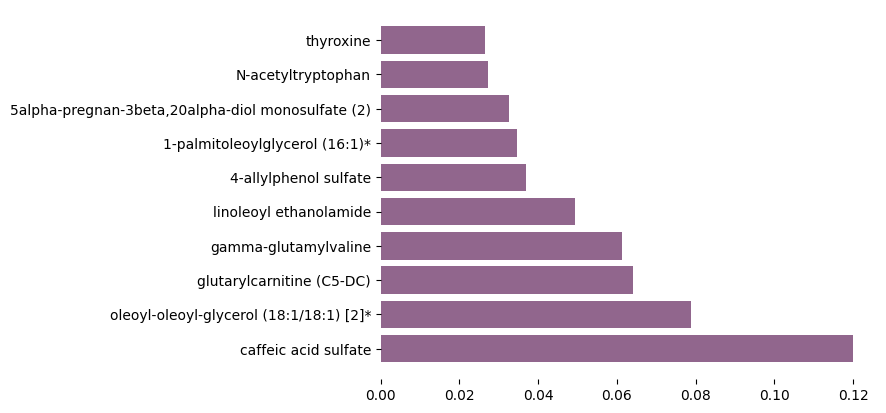

In [66]:
top10 = top_k_importances_stat(model_mrmr, 10)

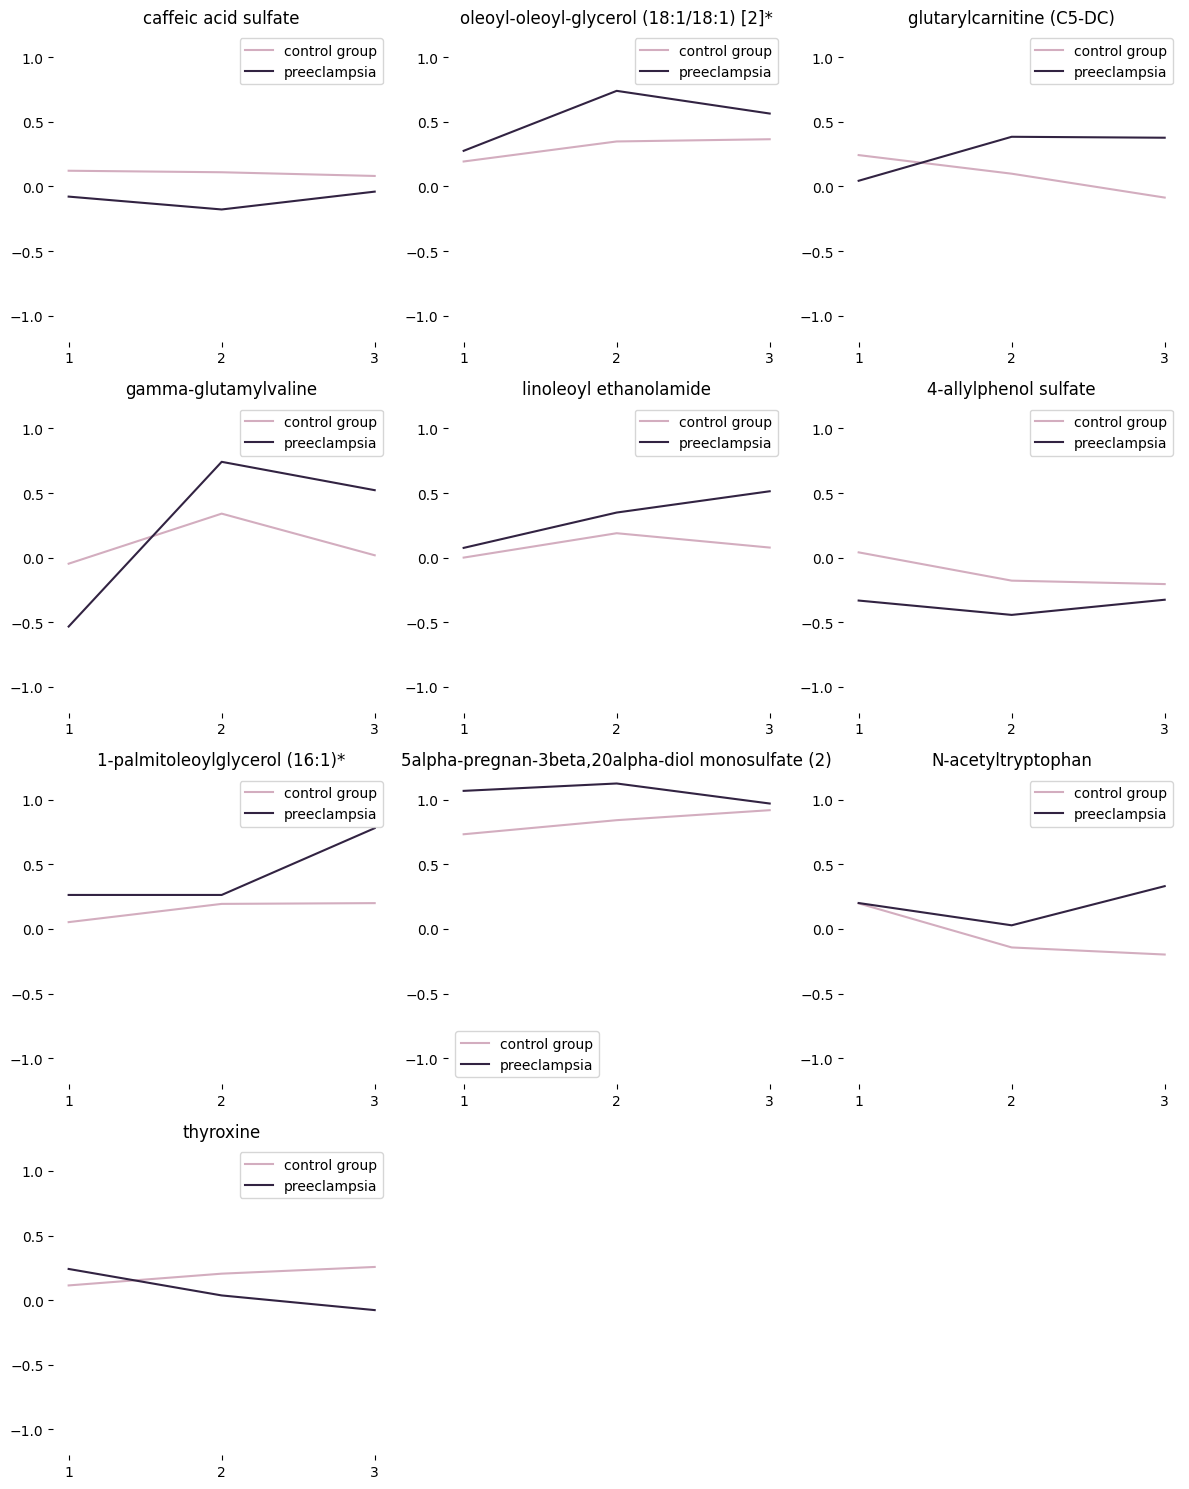

In [67]:
# plot for 10 most important metabolites
i = 1
plt.figure(figsize=(12, 15))
for m in top10.COMP_ID:
    if(m not in importances_mrmr):
        continue
        
    plt.subplot(4, 3, i)
    plt.plot(mean_values0.index, mean_values0[m], color='#d3adbf')
    plt.plot(mean_values1.index, mean_values1[m], color='#322342')
    
    plt.xticks(mean_values0.index)
    plt.legend(['control group', 'preeclampsia'])
    plt.ylim(-1.2, 1.2)
    
    [name] = top10[top10.COMP_ID == m].BIOCHEMICAL
    plt.title(name)
    plt.box(False)
    
    i += 1
    
plt.tight_layout()    
plt.show()

### Metabolites relation with BMI

BMI turned out to be invalid, weight is measured only ones instead of every trimester

In [68]:
def bmi_categories(row):
    if row.BMI < 18.5:
        return 1
    elif row.BMI < 25.0:
        return 2
    elif row.BMI < 30.0:
        return 3
    else:
        return 4


In [69]:
test_bmi = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X[importances_mrmr.keys()], on='sIDs', how='right')
test_bmi['BMI'] = test_bmi.apply(bmi_categories, axis=1)

group_bmi2 = test_bmi[test_bmi.BMI == 2]
group0_bmi2 = group_bmi2[group_bmi2.pe == 0].drop('pe', axis = 1)
group1_bmi2 = group_bmi2[group_bmi2.pe == 1].drop('pe', axis = 1)

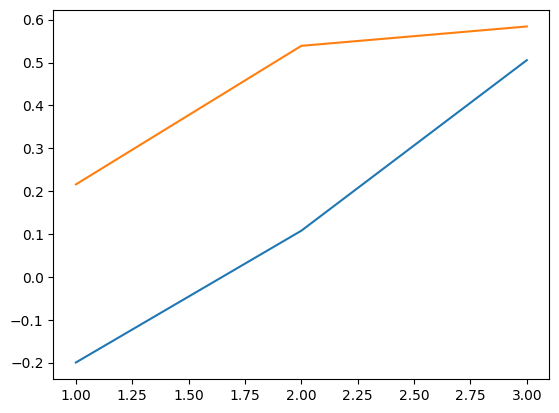

In [70]:
mean_02 = group0_bmi2.groupby('trimester').agg('mean')
mean_12 = group1_bmi2.groupby('trimester').agg('mean')

plt.plot(mean_02.index, mean_02[1769])
plt.plot(mean_12.index, mean_12[1769])

In [71]:
# no patients from bmi category 1:
test_bmi.BMI.value_counts()

2    140
4     84
3     81
Name: BMI, dtype: int64

In [72]:
stats.mannwhitneyu(group0_bmi2[group0_bmi2.trimester == 3][1769], group1_bmi2[group1_bmi2.trimester == 3][1769])

MannwhitneyuResult(statistic=256.0, pvalue=0.7496791566693759)

In [73]:
for bmi in range(2, 5):
    group_bmi2 = test_bmi[test_bmi.BMI == bmi]
    group0_bmi2 = group_bmi2[group_bmi2.pe == 0].drop('pe', axis = 1)
    group1_bmi2 = group_bmi2[group_bmi2.pe == 1].drop('pe', axis = 1)

    for m in top10.COMP_ID:
        for t in range(1, 4):
            s, p = stats.mannwhitneyu(group0_bmi2[group0_bmi2.trimester == t][m], group1_bmi2[group1_bmi2.trimester == t][m])
            if p < 0.05:
                print(f'met: {m}, bmi: {bmi}, trim: {t}, p-val: {p}')

met: 53254, bmi: 2, trim: 2, p-val: 0.014774042392111532
met: 54946, bmi: 2, trim: 2, p-val: 0.039204871478387686
met: 44664, bmi: 2, trim: 3, p-val: 0.04054284662909363
met: 43829, bmi: 2, trim: 1, p-val: 0.040923514607725135
met: 43829, bmi: 2, trim: 3, p-val: 0.028350442542573275
met: 52431, bmi: 2, trim: 1, p-val: 0.014911030550830607
met: 52431, bmi: 2, trim: 2, p-val: 0.016727315416444934
met: 37200, bmi: 2, trim: 2, p-val: 0.003862579041647307
met: 33959, bmi: 2, trim: 3, p-val: 0.013898790326539213
met: 53254, bmi: 3, trim: 1, p-val: 0.007128460801212721
met: 54946, bmi: 3, trim: 2, p-val: 0.049055642335885316
met: 54946, bmi: 3, trim: 3, p-val: 0.013830654589291119
met: 52608, bmi: 3, trim: 3, p-val: 0.03978845476907593
met: 52431, bmi: 3, trim: 3, p-val: 0.008412405029214752
met: 37200, bmi: 3, trim: 1, p-val: 0.019374416433239963
met: 37200, bmi: 3, trim: 2, p-val: 0.038707628800508063
met: 53254, bmi: 4, trim: 1, p-val: 0.023544102412552784
met: 44664, bmi: 4, trim: 3, p-va

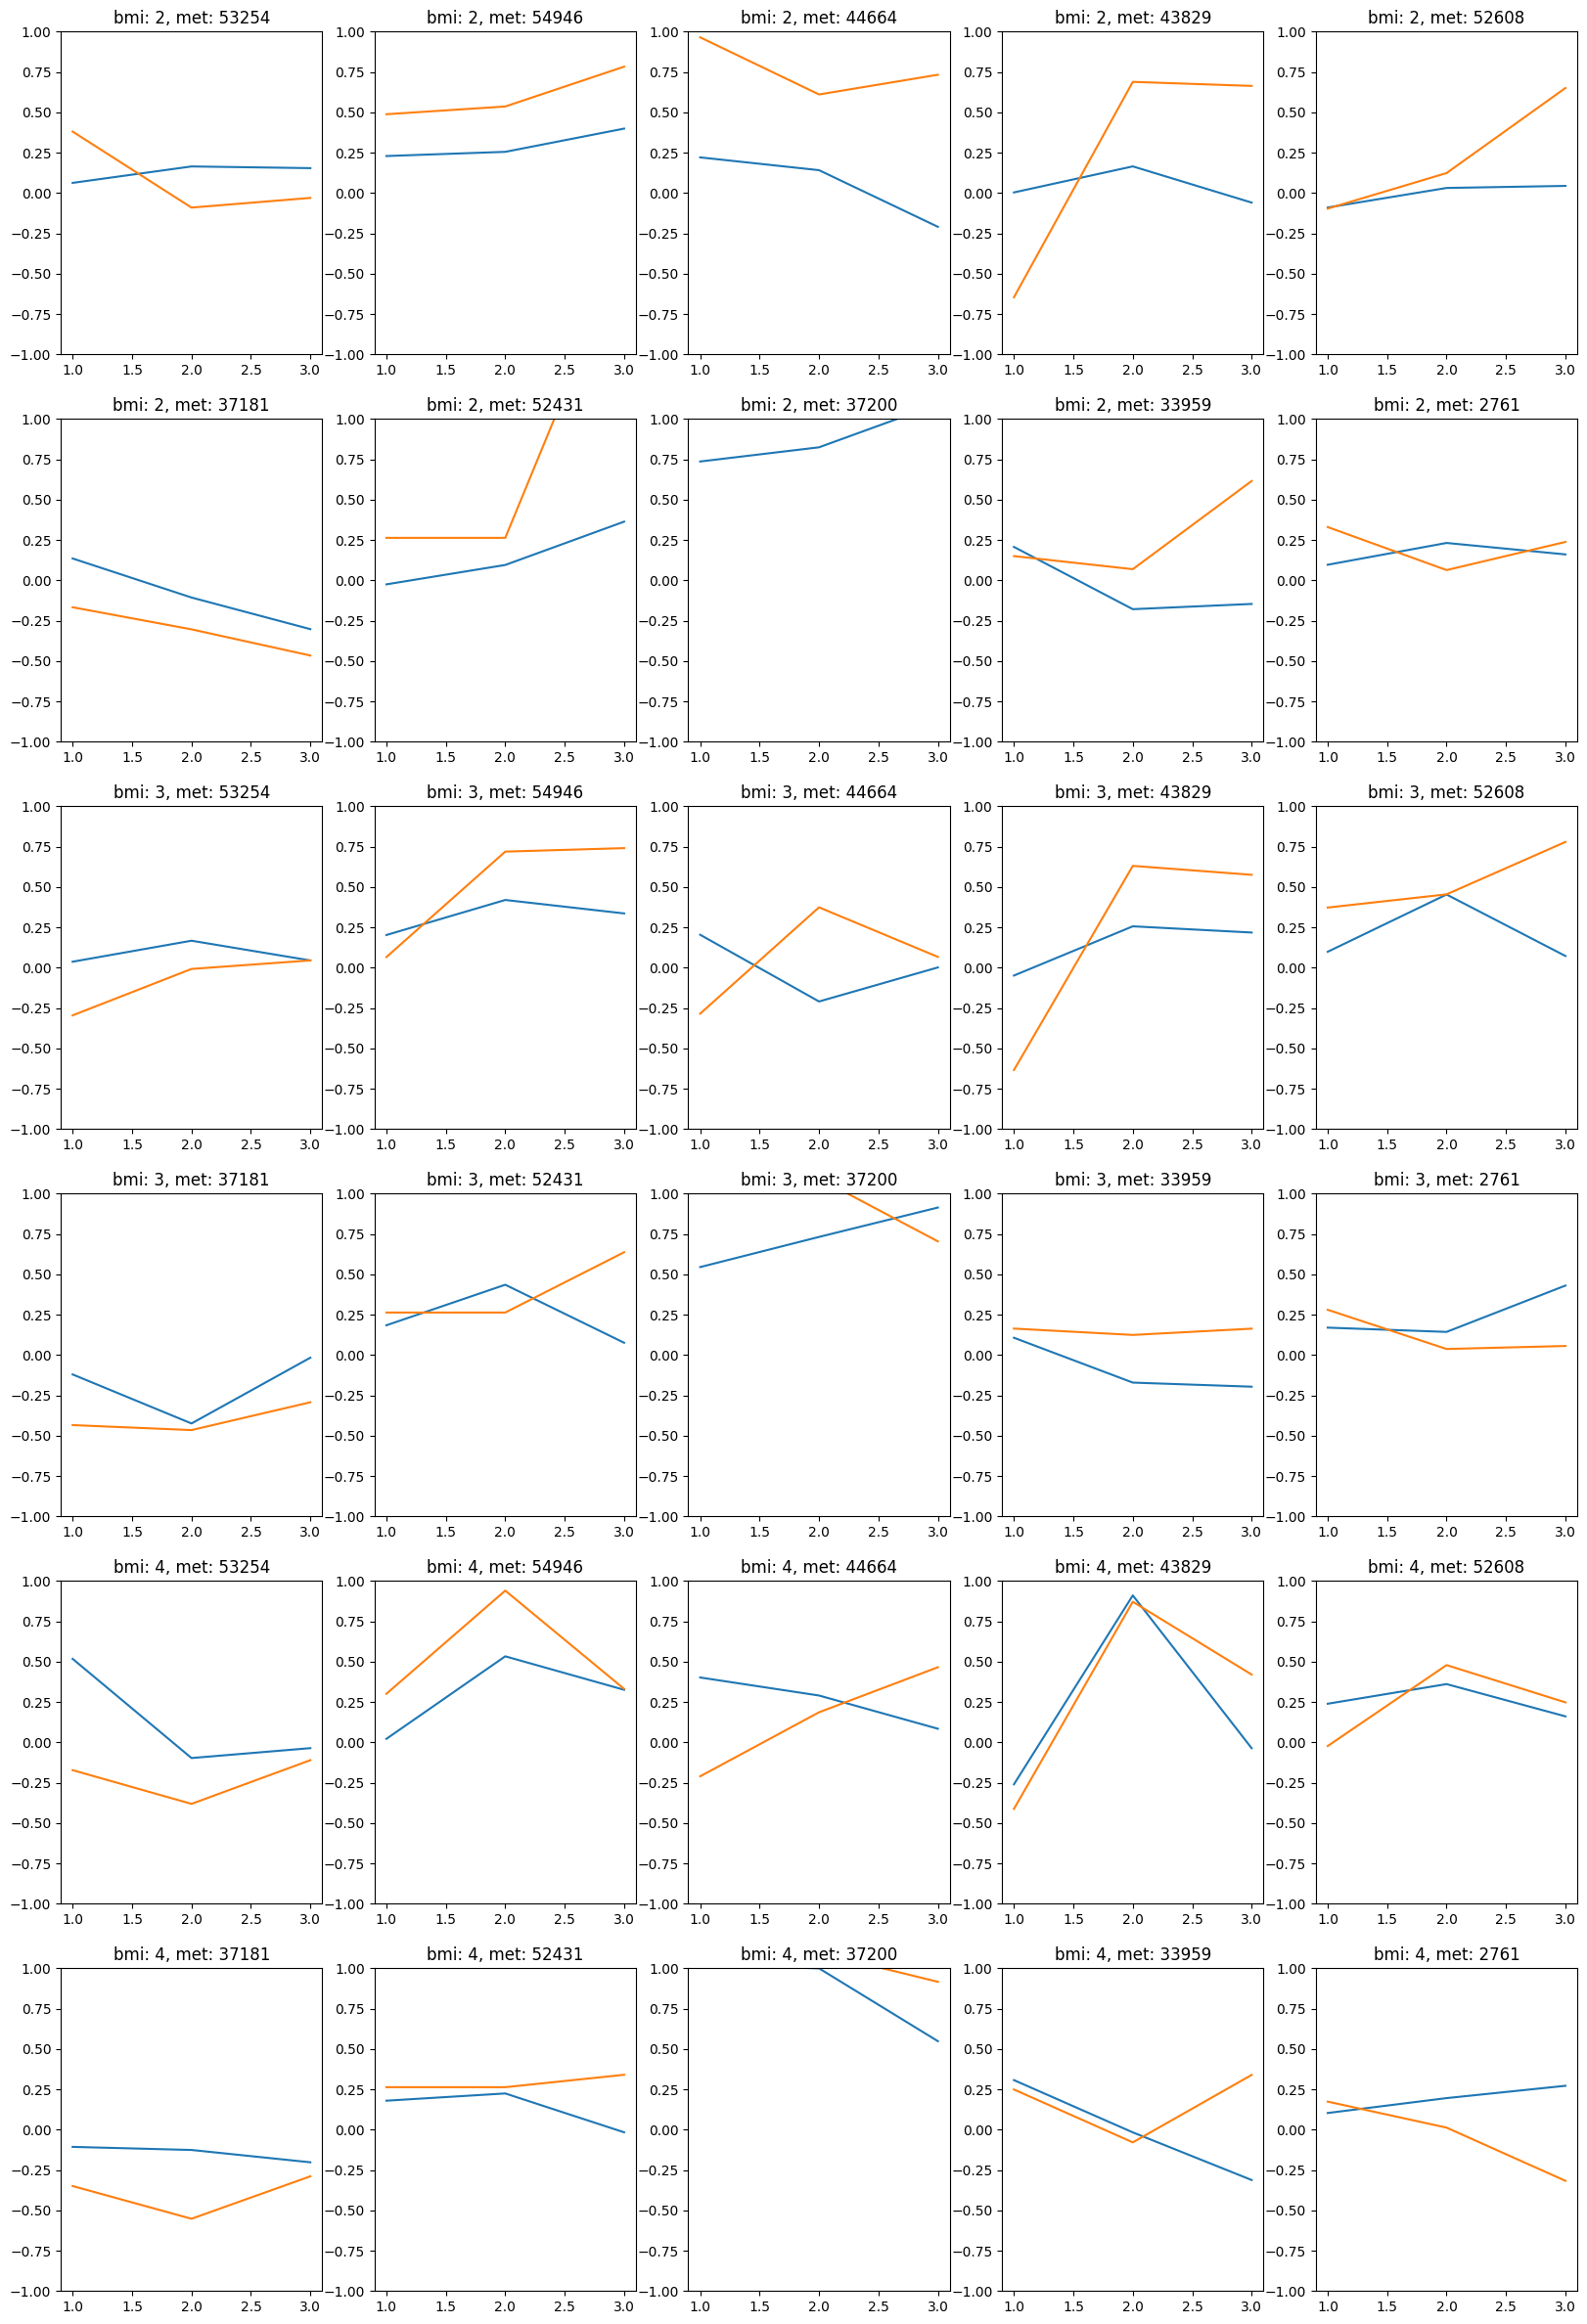

In [74]:

i = 1
plt.figure(figsize=(20, 30))
for bmi in range(2, 5):
    group_bmi2 = test_bmi[test_bmi.BMI == bmi]
    mean_02 = group_bmi2[group_bmi2.pe == 0].drop('pe', axis = 1).groupby('trimester').agg('mean')
    mean_12 = group_bmi2[group_bmi2.pe == 1].drop('pe', axis = 1).groupby('trimester').agg('mean')
    
    for m in top10.COMP_ID:
        plt.subplot(6, 5, i)
        plt.plot(mean_02.index, mean_02[m])
        plt.plot(mean_12.index, mean_12[m])
        plt.title(f'bmi: {bmi}, met: {m}')
        plt.ylim(-1, 1)
        i += 1
        
plt.show()

Metabolites and BMI correlation

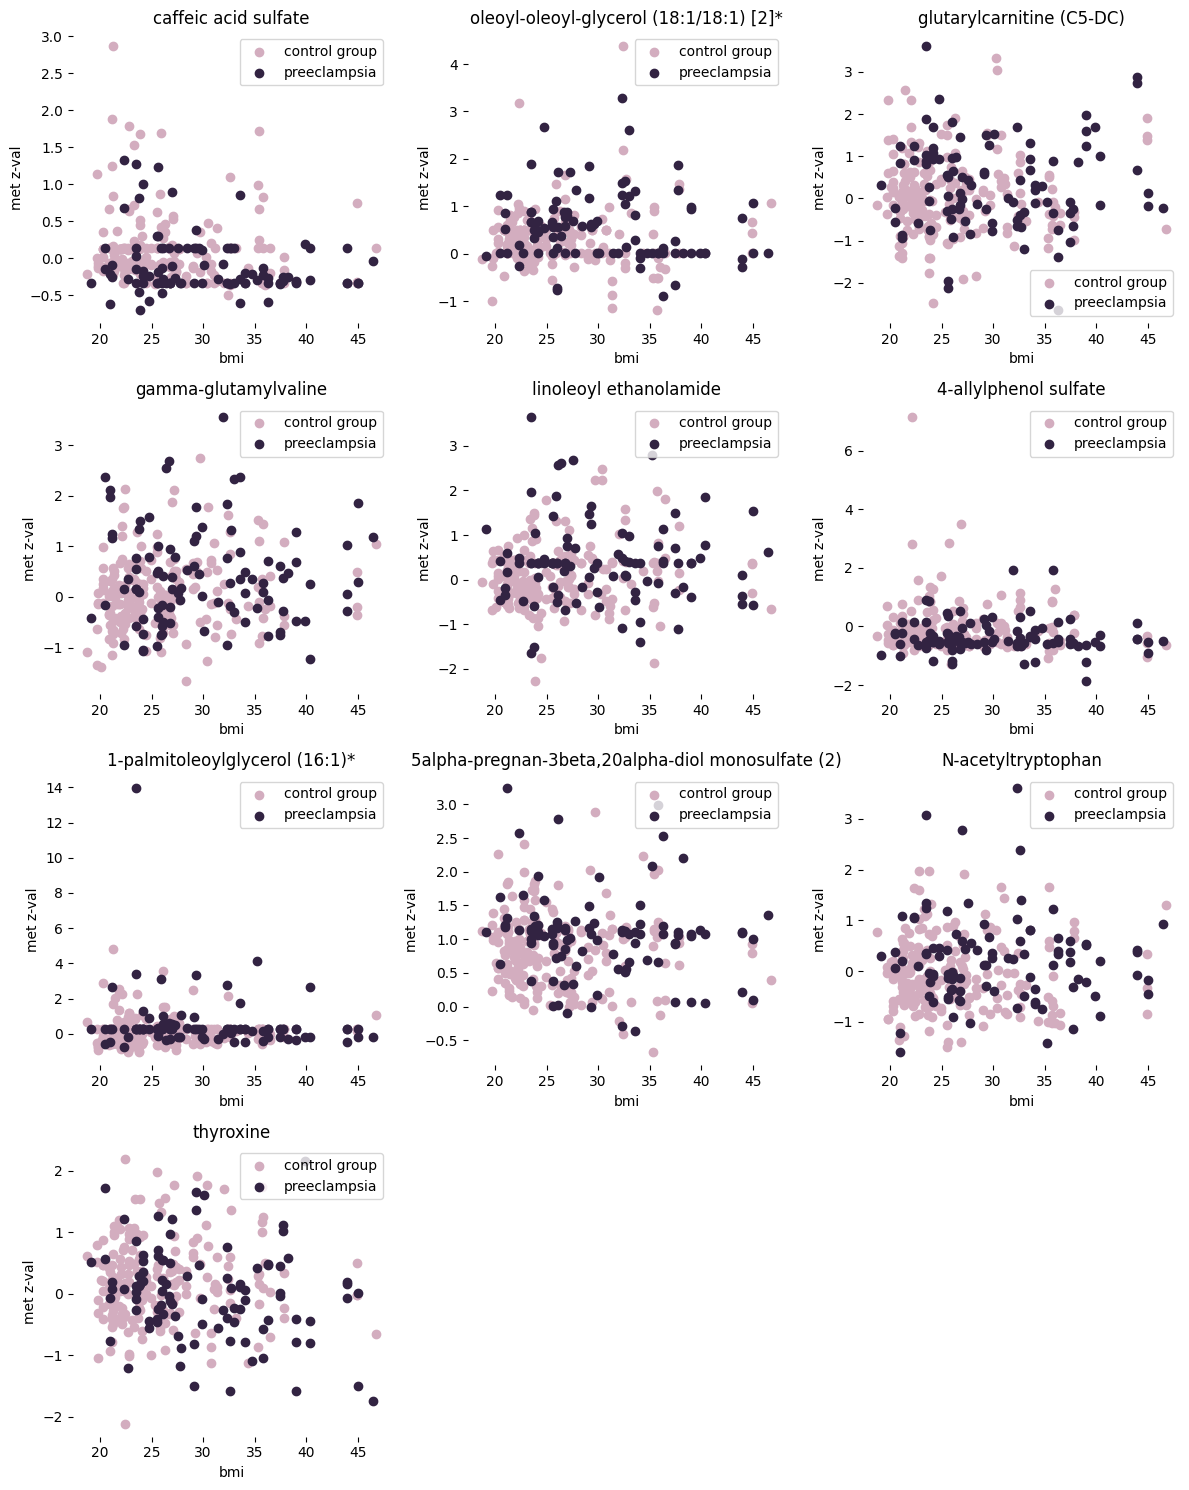

In [83]:
i = 1
test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X[importances_mrmr.keys()], on='sIDs', how='right')
bmi_met_corr = test.corr()['BMI'][3:]

plt.figure(figsize=(12, 15))
for met_id in top10.COMP_ID:

    plt.subplot(4, 3, i)
    plt.scatter(test.BMI[test.pe == 0], test[met_id][test.pe == 0], color='#d3adbf')
    plt.scatter(test.BMI[test.pe == 1], test[met_id][test.pe == 1], color='#322342')

    plt.legend(['control group', 'preeclampsia'])
    
    [name] = top10[top10.COMP_ID == met_id].BIOCHEMICAL
    plt.title(name)
    plt.box(False)

    plt.xlabel('bmi')
    plt.ylabel('met z-val')
    i += 1
    
plt.tight_layout()
plt.show()

In [84]:
bmi_met_corr

53254   -0.171070
54946    0.019896
44664    0.059923
43829    0.113343
52608    0.093402
37181   -0.081540
52431   -0.023932
37200   -0.064032
33959    0.032421
2761    -0.107379
37184    0.127090
52500   -0.238707
1769     0.062543
37185    0.003091
27710   -0.116238
40008    0.070840
21025   -0.063558
36098   -0.207201
40708    0.066879
32827    0.044905
15122    0.149125
32391   -0.018595
57591   -0.111339
57637   -0.187596
42459    0.230575
48457   -0.132346
15500   -0.072013
32417    0.118209
52988    0.209996
62059   -0.080032
45095    0.007113
52465    0.045729
Name: BMI, dtype: float64

In [85]:
bmi_met_corr.max()

0.23057493035896784

In [86]:
bmi_met_corr.min()

-0.23870714234341361

In [87]:
test1 = test[test.trimester == 1]

In [88]:
bmi_met_corr1 = test1.corr()['BMI'][3:]

In [89]:
bmi_met_corr1

53254    0.045951
54946   -0.051656
44664   -0.057651
43829   -0.174282
52608    0.152820
37181   -0.099038
52431    0.193314
37200    0.222079
33959    0.031701
2761     0.067300
37184    0.099761
52500   -0.097235
1769     0.239587
37185   -0.004314
27710   -0.160178
40008    0.001642
21025   -0.129530
36098   -0.172939
40708    0.463460
32827    0.113144
15122    0.323736
32391   -0.082241
57591   -0.116508
57637   -0.263323
42459    0.309482
48457   -0.240986
15500   -0.161154
32417    0.238908
52988    0.246576
62059   -0.113855
45095    0.072731
52465    0.374279
Name: BMI, dtype: float64

In [90]:
bmi_met_corr1.max()

0.4634604787812966

In [91]:
bmi_met_corr1.argmax()

18

In [92]:
from matplotlib.colors import LinearSegmentedColormap

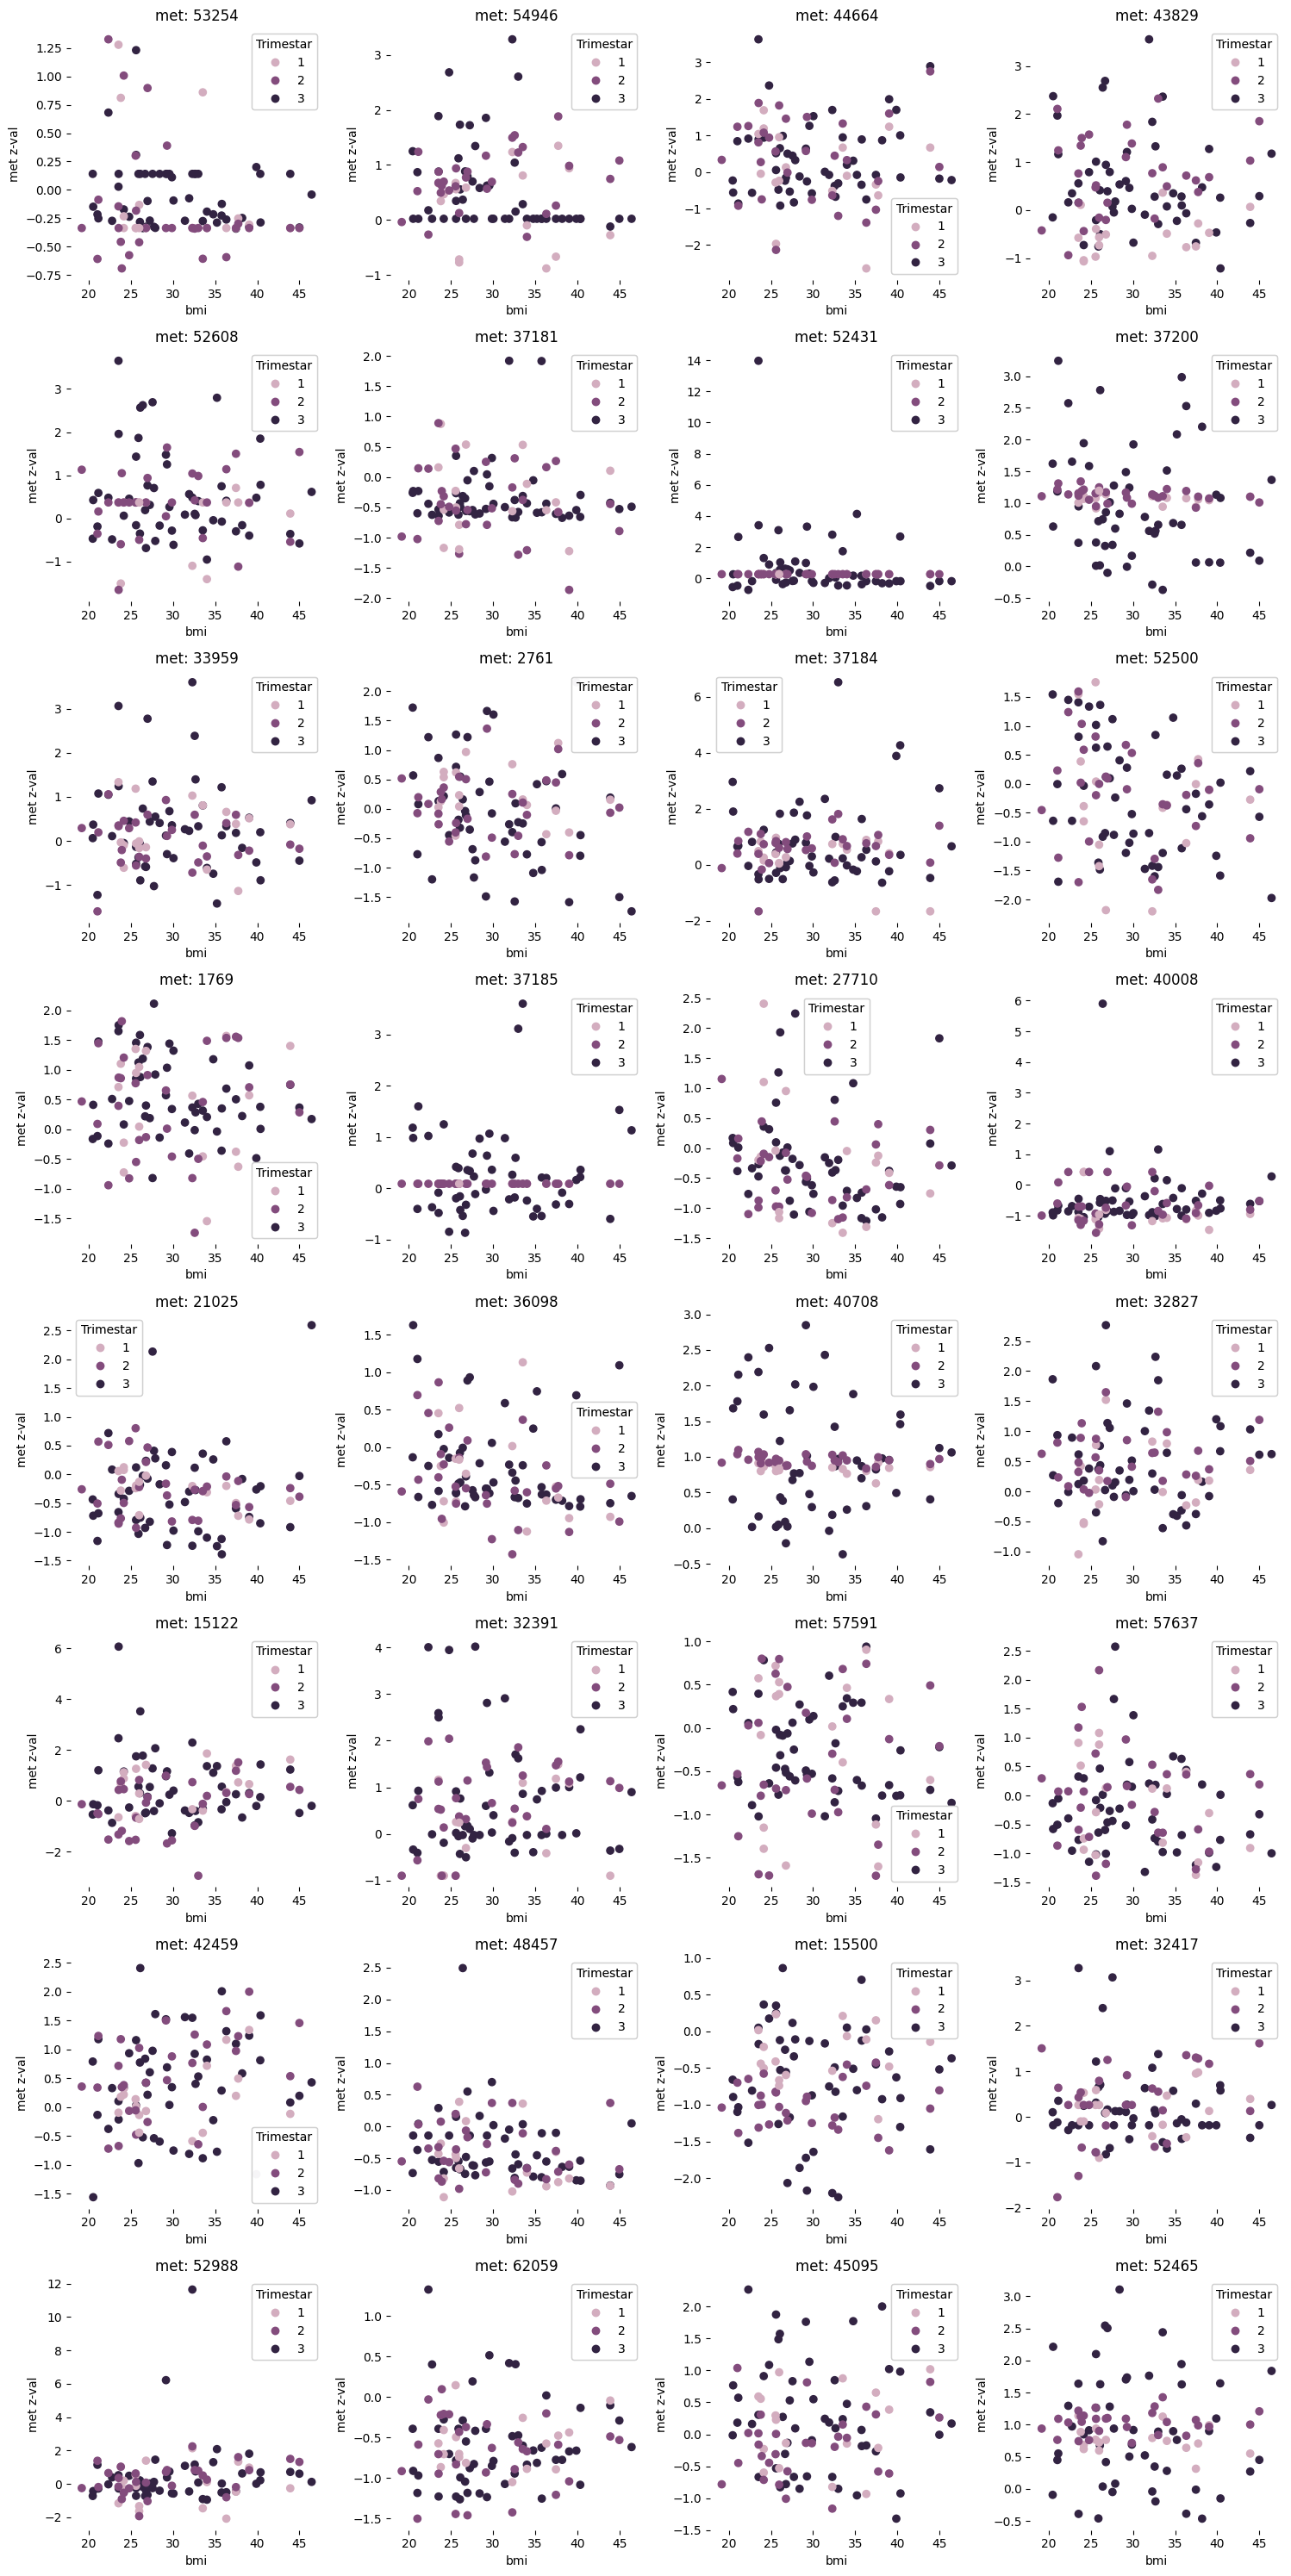

In [93]:
i = 1
test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

plt.figure(figsize=(15, 30))
for met_id in importances_mrmr.keys():

    cs = ['#d3adbf', '#834c7d', '#322342']
    cmap = LinearSegmentedColormap.from_list('proba', cs)
    ax = plt.subplot(8, 4, i)
    scatter = plt.scatter(test.BMI[test.pe == 1], test[met_id][test.pe == 1], c=test[test.pe == 1].trimester, cmap=cmap)
#     plt.scatter(test.BMI[test.pe == 1], test[met_id][test.pe == 1])

#     plt.legend([1, 2, 3])
    legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Trimestar")
    ax.add_artist(legend1)
    
    plt.box(False)
    plt.title(f'met: {met_id}')
    plt.xlabel('bmi')
    plt.ylabel('met z-val')
    i += 1
    
plt.tight_layout()
plt.show()

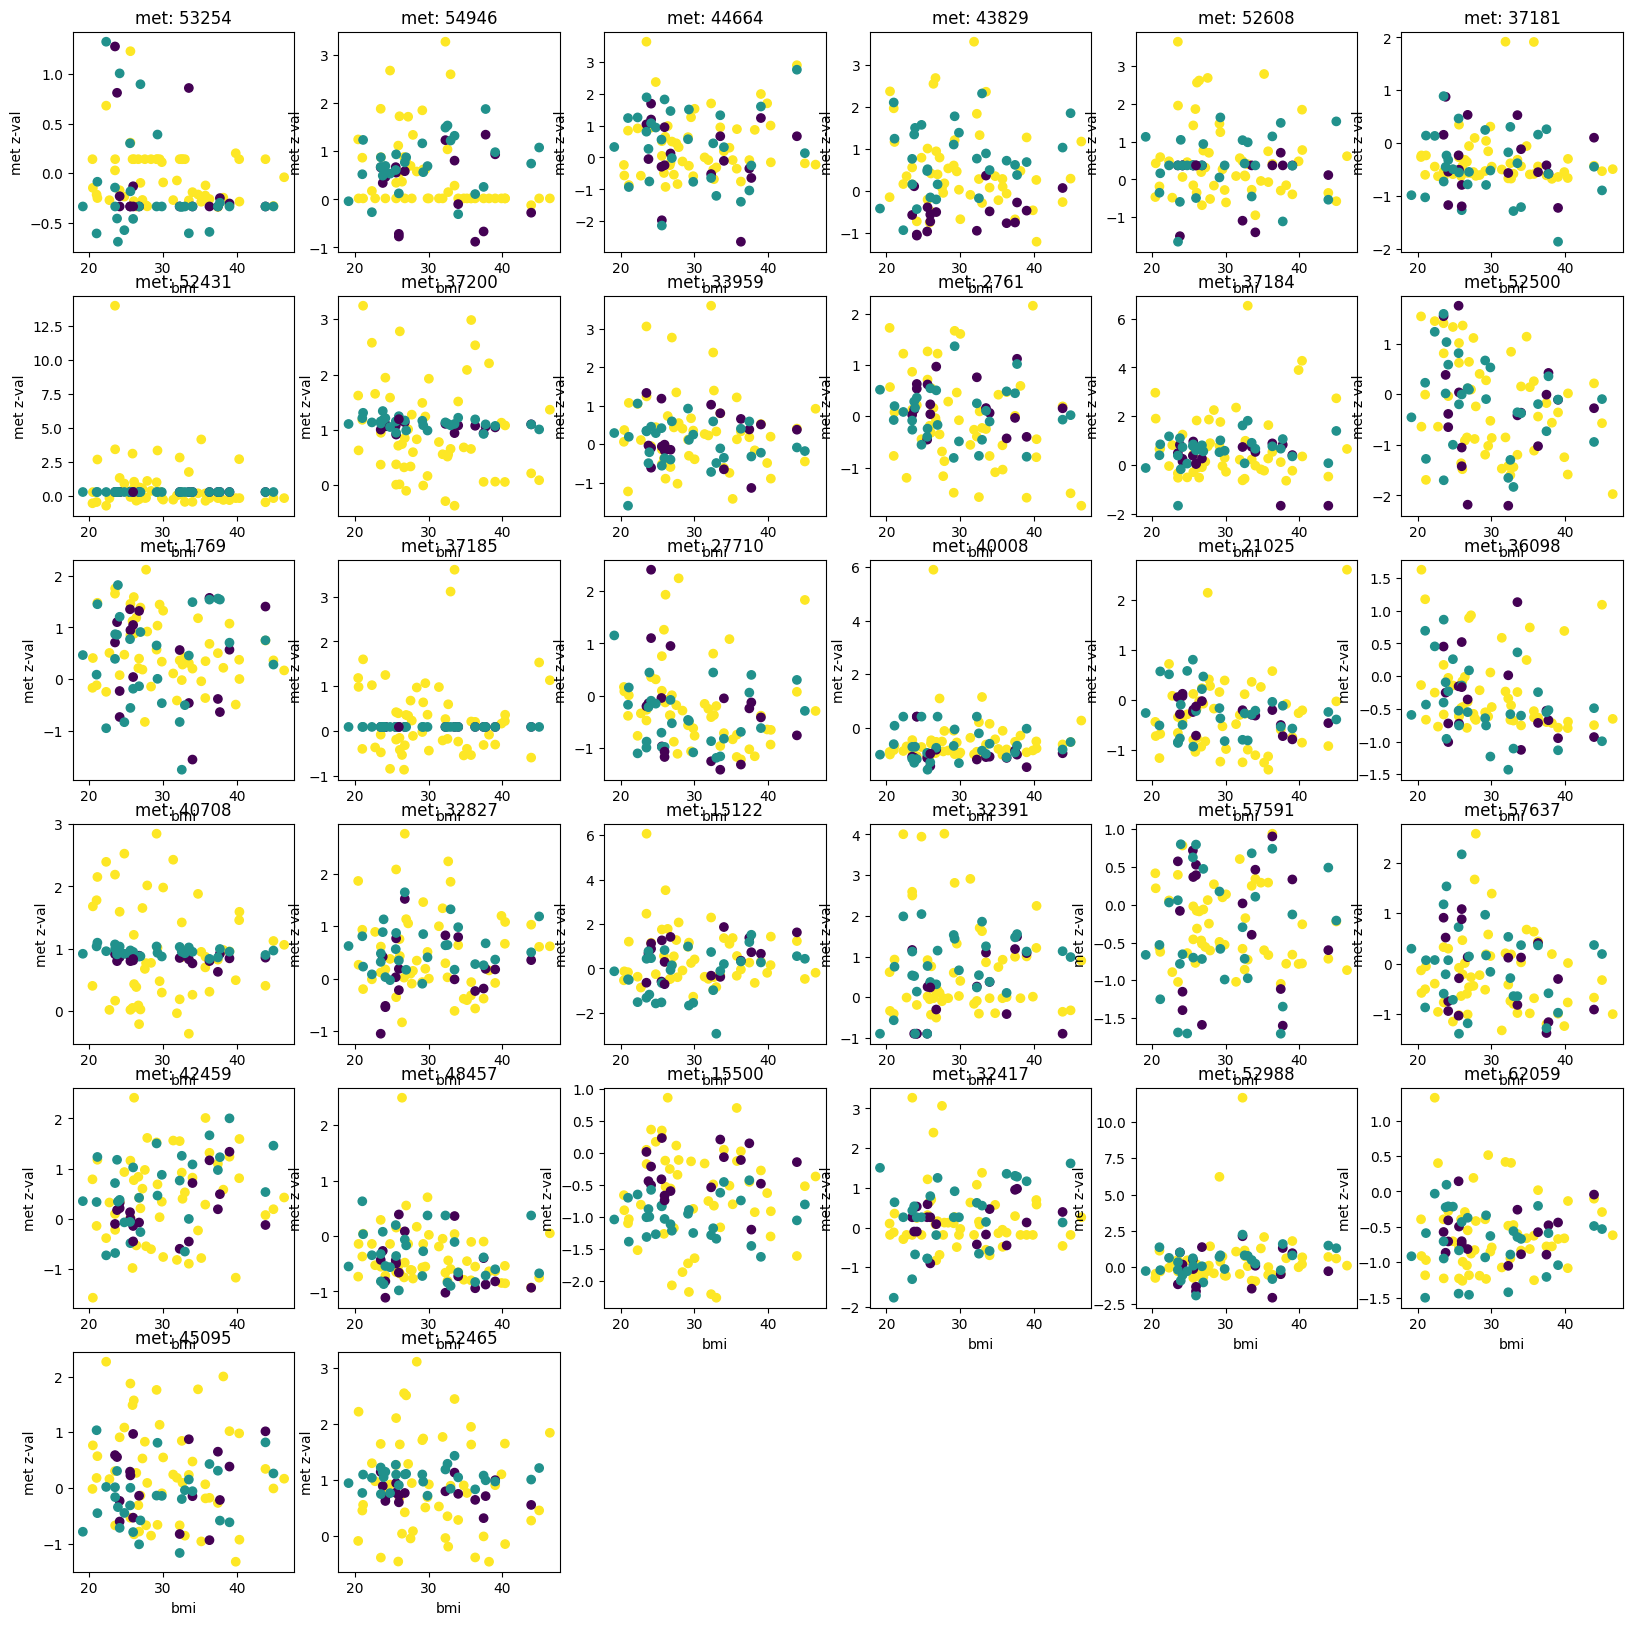

In [94]:
i = 1
test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

plt.figure(figsize=(20, 20))
for met_id in importances_mrmr.keys():

    plt.subplot(6, 6, i)
#     plt.scatter(test.BMI[test.pe == 0], test[met_id][test.pe == 0], c=test[test.pe == 0].trimester)
    plt.scatter(test.BMI[test.pe == 1], test[met_id][test.pe == 1], c=test[test.pe == 1].trimester)

#     plt.legend([0, 1])
    plt.title(f'met: {met_id}')
    plt.xlabel('bmi')
    plt.ylabel('met z-val')
    i += 1
plt.show()

Check correlation with metabolites that are not among most important features

In [96]:
test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X, on='sIDs', how='right')
bmi_met_corr = test.corr()['BMI'][3:]

In [97]:
bmi_met_corr.max()

0.3629719520033358

In [98]:
bmi_met_corr.min()

-0.33050009839220845

In [99]:
# ne postoje vrednosti blizu 1/-1

In [100]:
inds = []
for t in range(1, 4):
    bmi_met_corr = test[test.trimester == t].corr()['BMI'][3:]
    inds += [bmi_met_corr.index[i] for i, x in enumerate(bmi_met_corr) if x > 0.5 or x < -0.5]
    print([(bmi_met_corr.index[i], x) for i, x in enumerate(bmi_met_corr) if x > 0.5 or x < -0.5])


[(18368, 0.6283242277770572), (46172, 0.5065154544661632), (62103, 0.6211635037728742), (54961, 0.5154344301159344)]
[]
[]


In [101]:
comp_df[comp_df.COMP_ID.isin(inds)]

BIOCHEMICAL  PATHWAY_SORTORDER  \
157                              cys-gly, oxidized              586.0   
452                  5alpha-pregnan-diol disulfate             3301.0   
486                    cysteinylglycine disulfide*              585.0   
727  oleoyl-arachidonoyl-glycerol (18:1/20:4) [2]*             2959.0   

    SUPER_PATHWAY             SUB_PATHWAY  COMP_ID   PLATFORM  CHEMICAL_ID  \
157    Amino Acid  Glutathione Metabolism    18368  Pos Early         1224   
452         Lipid      Progestin Steroids    46172        Neg    100002015   
486    Amino Acid  Glutathione Metabolism    62103  Pos Early    100002466   
727         Lipid          Diacylglycerol    54961   Pos Late    100010937   

             PUBCHEM         CAS KEGG                  HMDB_ID  
157           333293   7729-20-6  NaN                      NaN  
452  3082277,5127902         NaN  NaN  HMDB0240581,HMDB0240582  
486         22833544  70555-24-7  NaN              HMDB0000709  
727          9543786         NaN  NaN              HMDB0007228

### Correlation with age

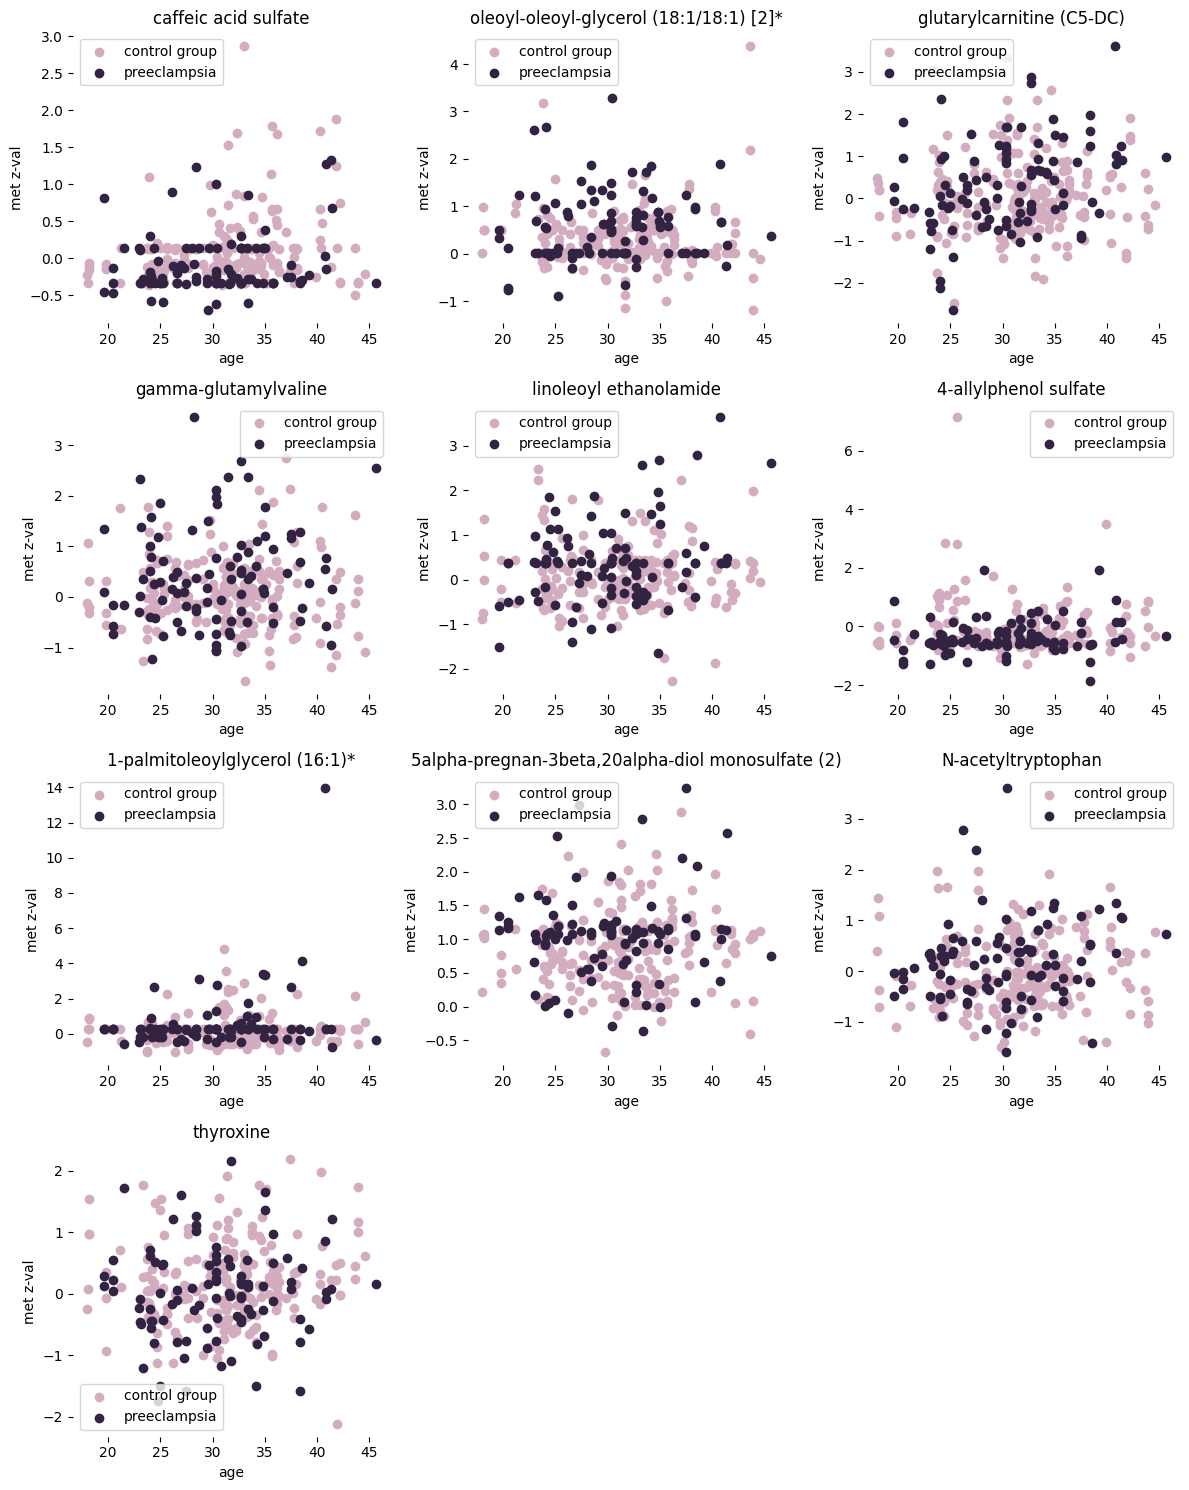

In [103]:
i = 1
test = clin_df[['trimester', 'sIDs', 'pe', 'age']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

plt.figure(figsize=(12, 15))
for met_id in top10.COMP_ID:

    plt.subplot(4, 3, i)
    plt.scatter(test.age[test.pe == 0], test[met_id][test.pe == 0], color='#d3adbf')
    plt.scatter(test.age[test.pe == 1], test[met_id][test.pe == 1], color='#322342')

    [name] = top10[top10.COMP_ID == met_id].BIOCHEMICAL
    plt.title(name)
    plt.box(False)
    
    plt.legend(['control group', 'preeclampsia'])
    plt.xlabel('age')
    plt.ylabel('met z-val')
    i += 1
    
plt.tight_layout()
plt.show()

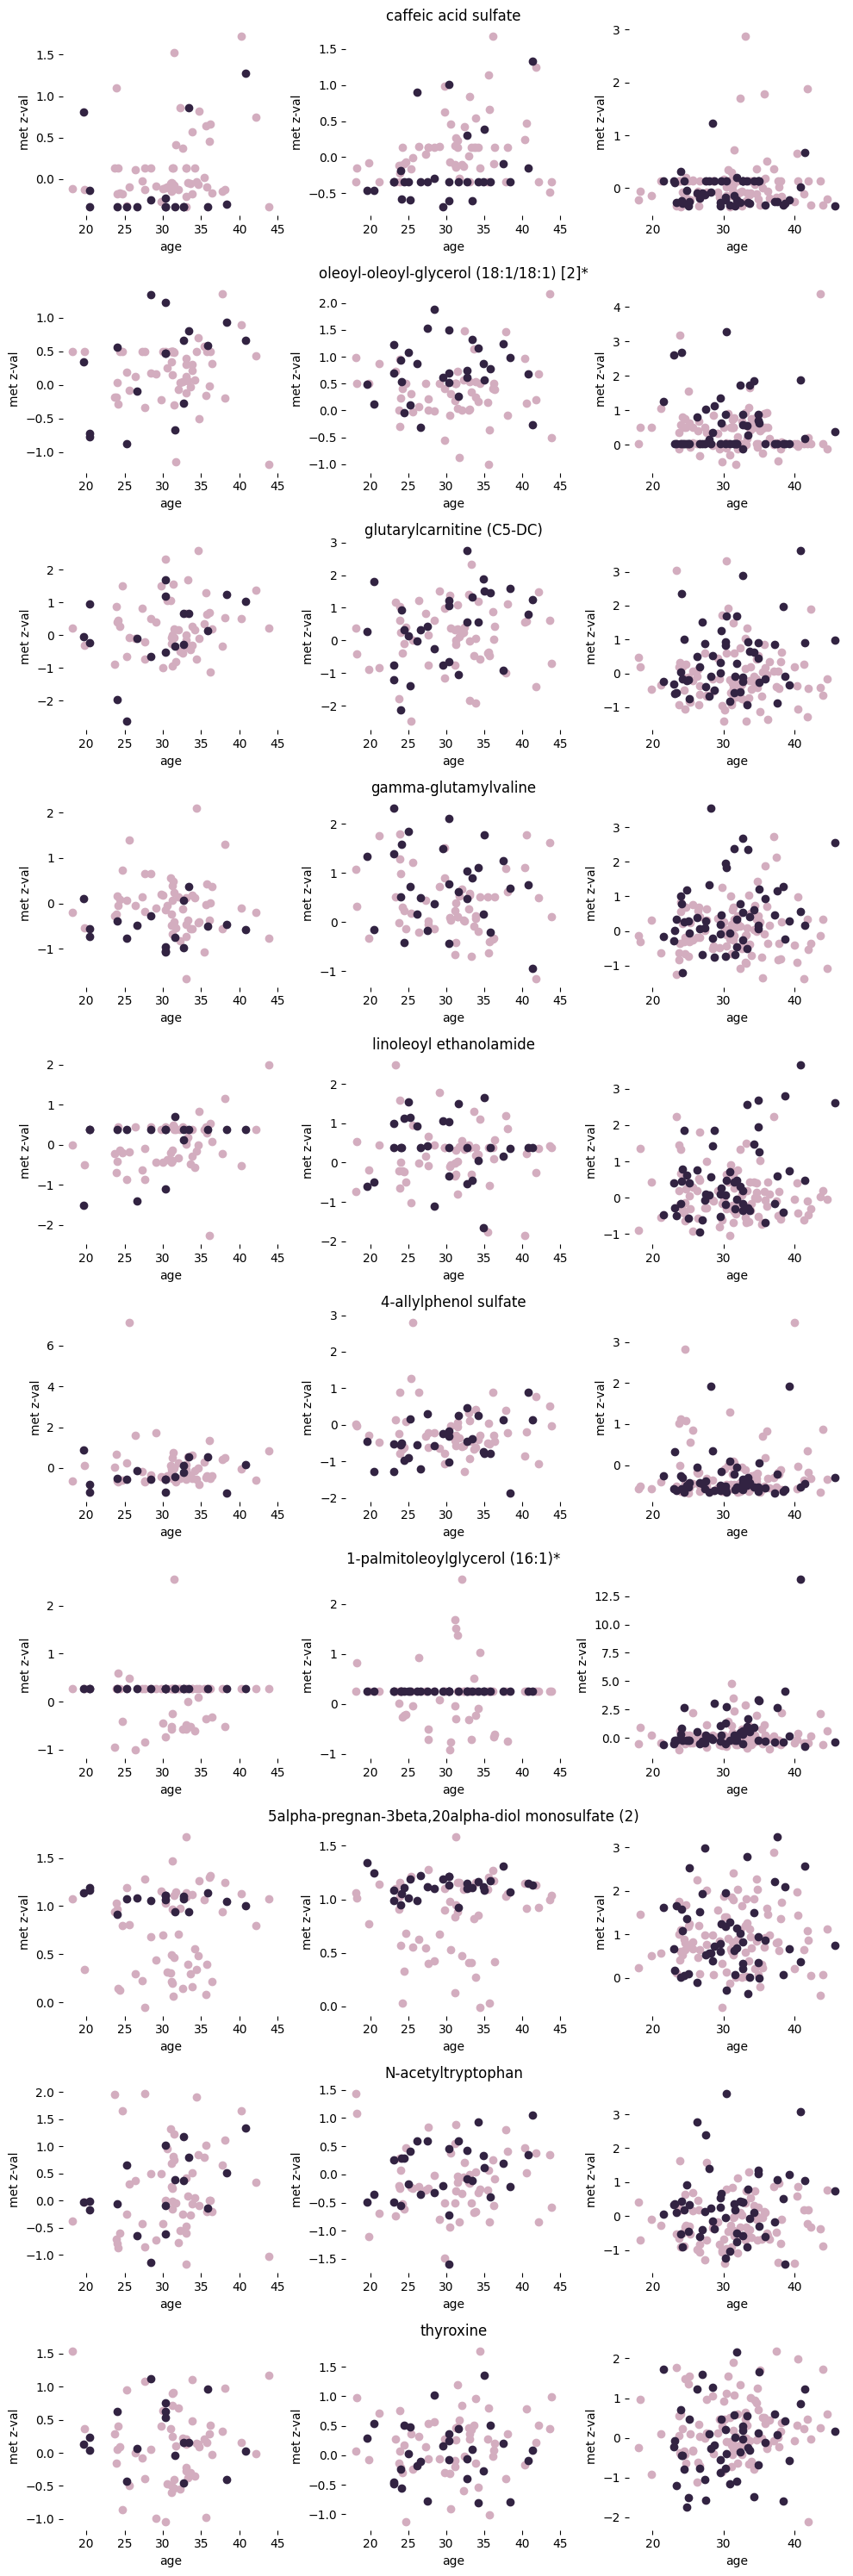

In [126]:
i = 1
test = clin_df[['trimester', 'sIDs', 'pe', 'age', 'ASA']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

plt.figure(figsize=(10, 30))
for met_id in top10.COMP_ID:
    for t in range(1, 4):
        
        plt.subplot(10, 3, i)
        test_t = test[test.trimester == t]
        plt.scatter(test_t.age[test_t.pe == 0], test_t[met_id][test_t.pe == 0], color='#d3adbf')
        plt.scatter(test_t.age[test_t.pe == 1], test_t[met_id][test_t.pe == 1], color='#322342')

        if t == 2:
            
            [name] = top10[top10.COMP_ID == met_id].BIOCHEMICAL
            plt.title(name)
        
        plt.box(False)
    
#         plt.legend(['control group', 'preeclampsia'])
        plt.xlabel('age')
        plt.ylabel('met z-val')
        i += 1
        

    
    
plt.tight_layout()
plt.show()

In [104]:
test.corr()['age'][3:]

53254    0.207958
54946   -0.000746
44664    0.122624
43829   -0.010232
52608    0.080969
37181    0.030647
52431    0.105606
37200    0.033957
33959    0.094985
2761     0.085877
37184   -0.203060
52500    0.119115
1769     0.010653
37185   -0.065930
27710    0.186141
40008    0.078127
21025    0.007778
36098    0.026634
40708    0.086958
32827   -0.208197
15122    0.131092
32391    0.042419
57591    0.193781
57637    0.043256
42459   -0.084565
48457    0.119681
15500    0.001348
32417   -0.072693
52988    0.025674
62059    0.029587
45095    0.030649
52465    0.083465
Name: age, dtype: float64

In [105]:
test = clin_df[['trimester', 'sIDs', 'pe', 'age']].join(X, on='sIDs', how='right')

In [106]:
age_corr_df = test.corr()['age'][3:]

In [107]:
age_corr_df

42370    0.030723
485     -0.058232
27665    0.024405
38395    0.108393
437      0.080668
           ...   
62292    0.036255
62295   -0.067265
62296   -0.059114
62297   -0.080038
62299   -0.055920
Name: age, Length: 798, dtype: float64

In [108]:
age_corr_df.min()

-0.3158342909594923

In [109]:
age_corr_df.max()

0.3144210024013628

In [110]:
for t in range(1, 4):
    bmi_met_corr1 = test[test.trimester == t].corr()['age'][3:]
    print(bmi_met_corr1.min(), bmi_met_corr1.max())

-0.3625402467165015 0.3936447403972269
-0.32766081235347444 0.36888356090121294
-0.3997191705812144 0.3539845472442021


### Change through trimesters for individual samples

Not enough samples with PE with all trimesters available (only 2 patients with PE have sample from each trimester)

In [112]:
trimester_df = clin_df[['trimester', 'sIDs', 'pe', 'ptIDs']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

In [113]:
trimester_plt = [(key, inds) for key, inds in trimester_df.groupby('ptIDs').groups.items() if len(inds) == 3]

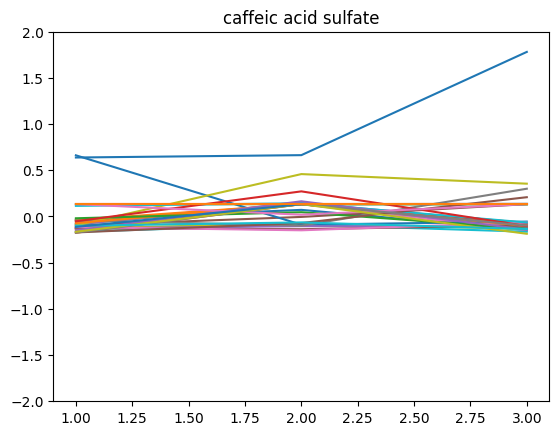

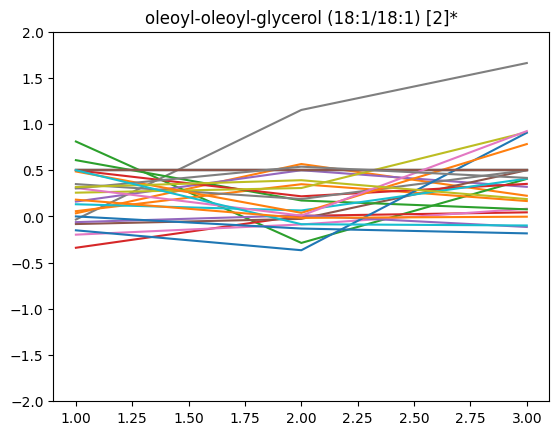

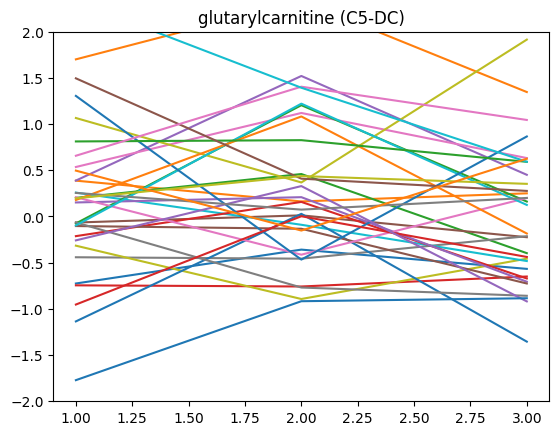

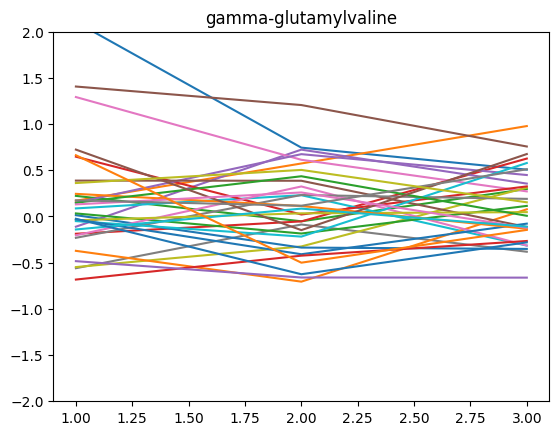

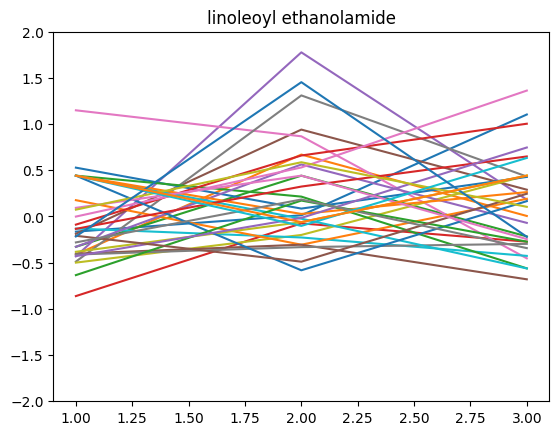

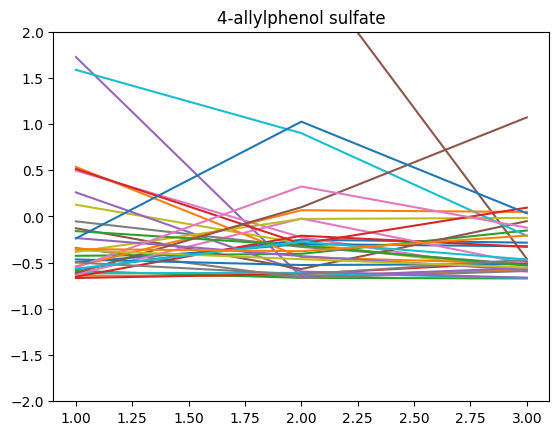

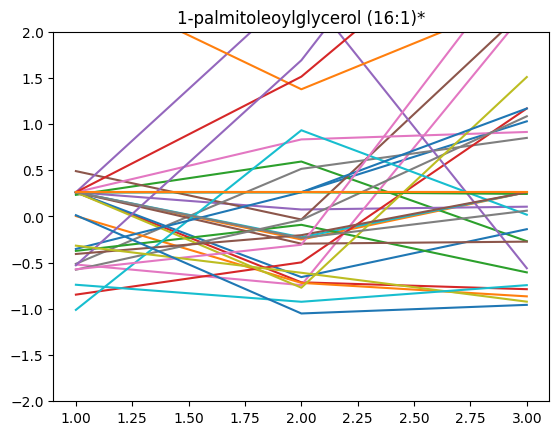

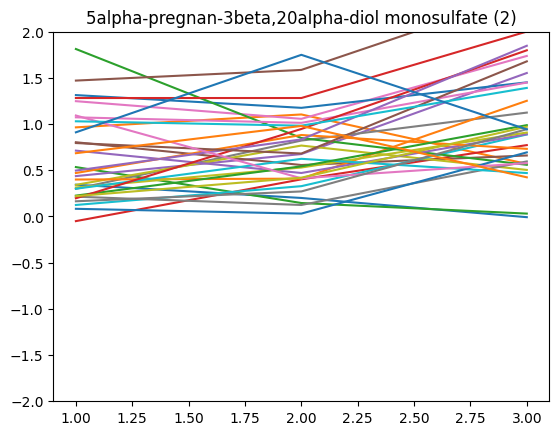

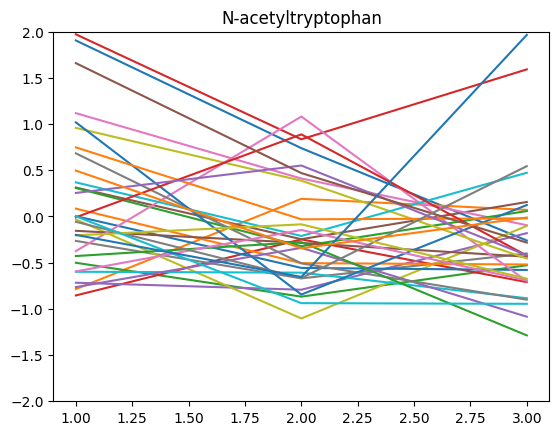

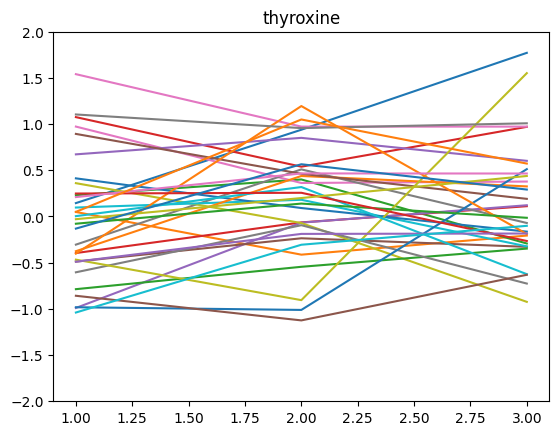

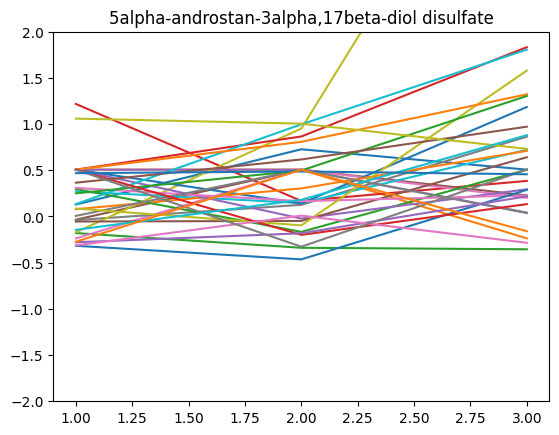

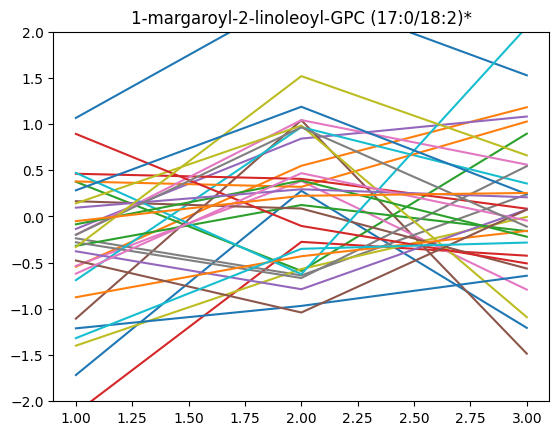

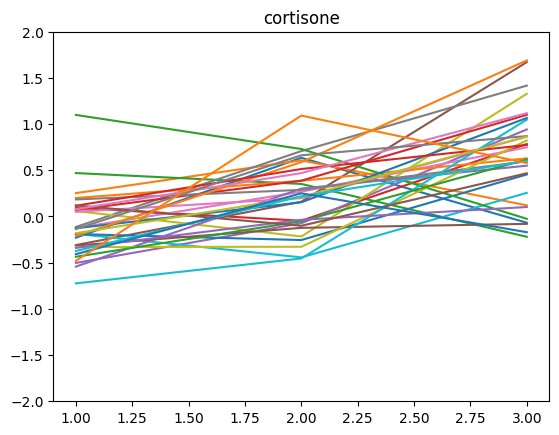

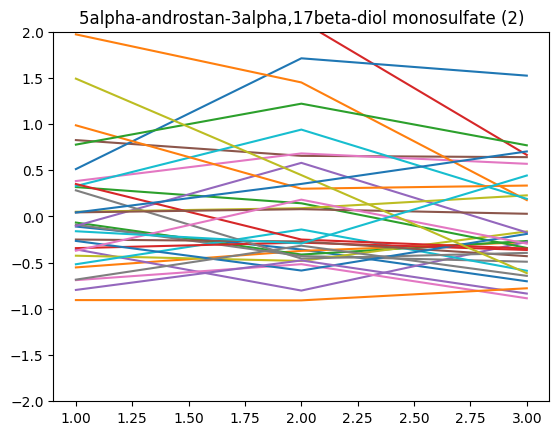

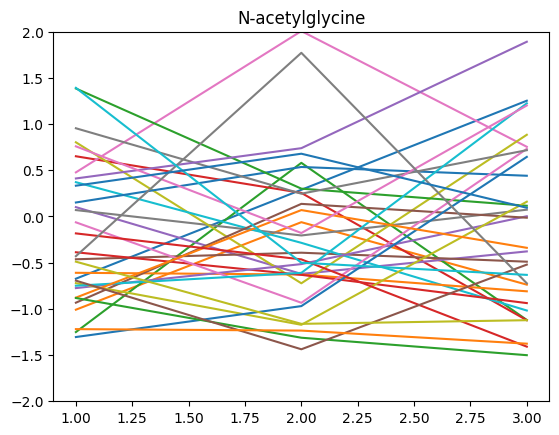

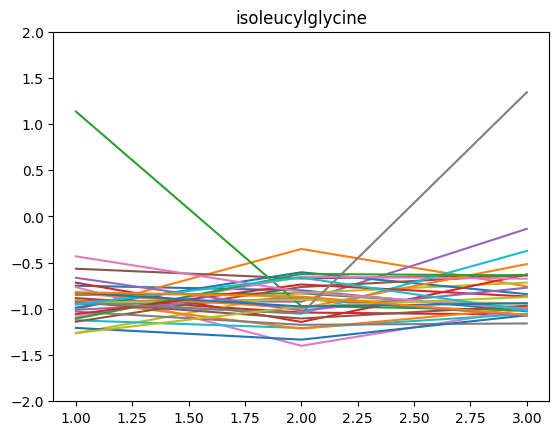

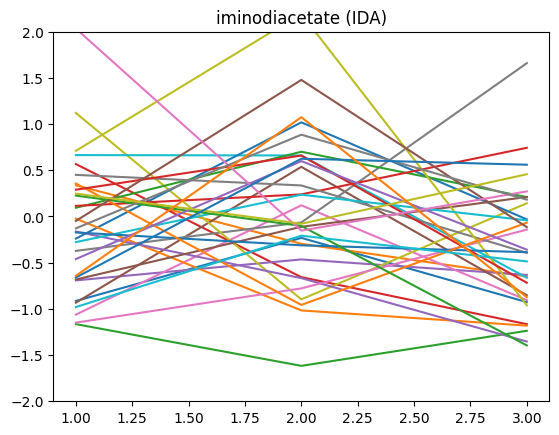

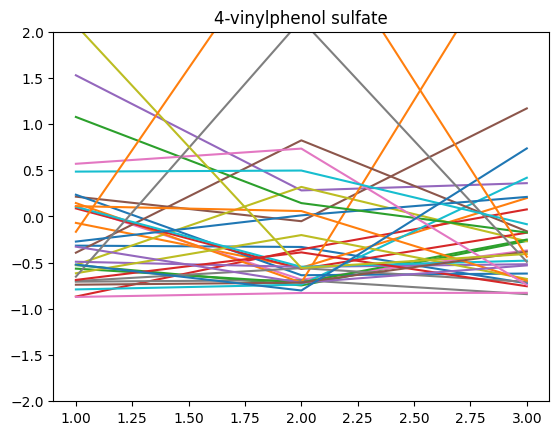

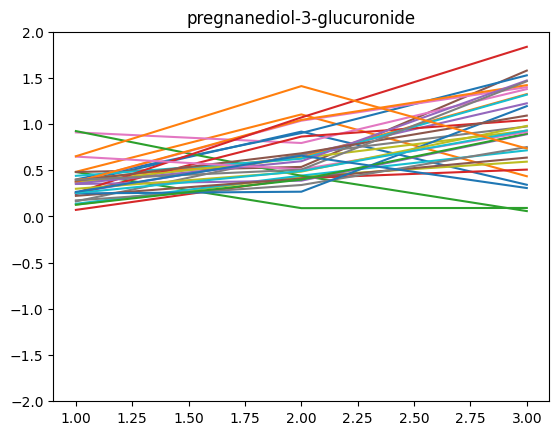

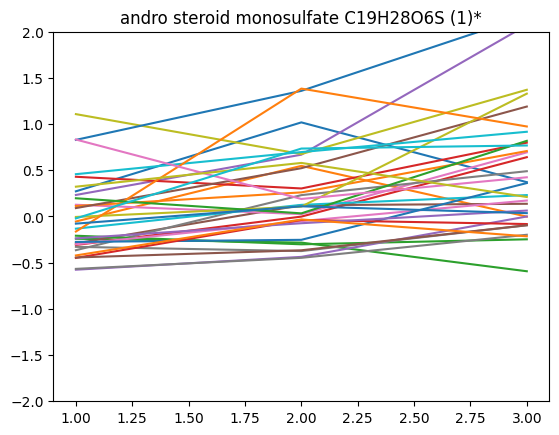

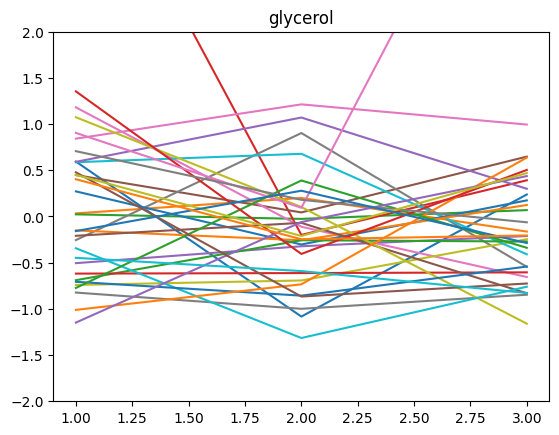

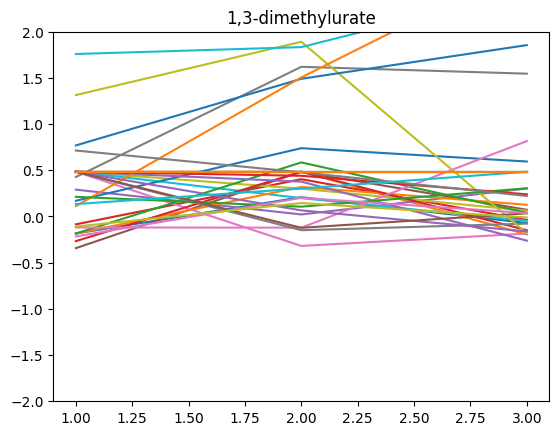

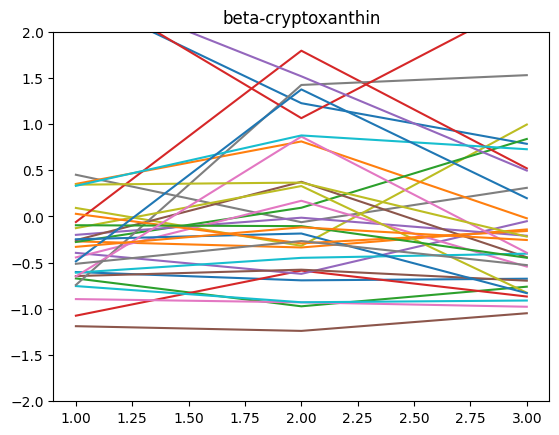

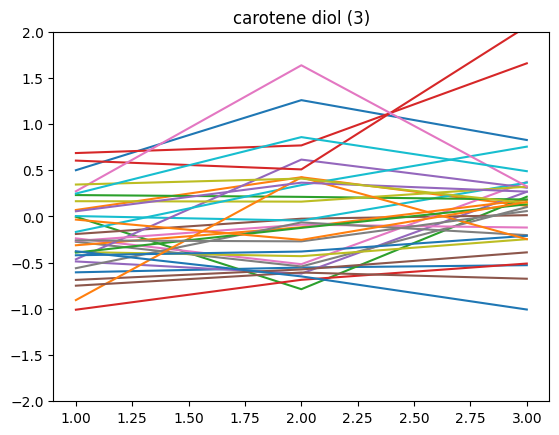

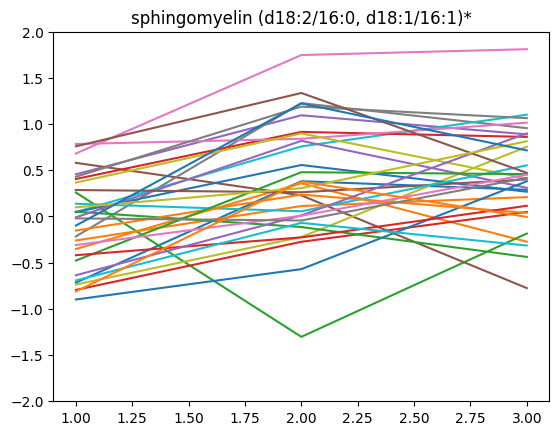

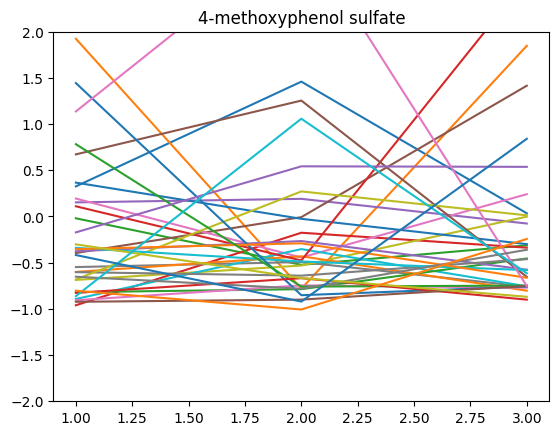

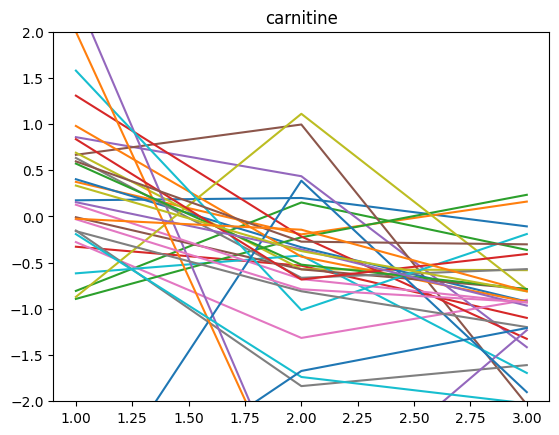

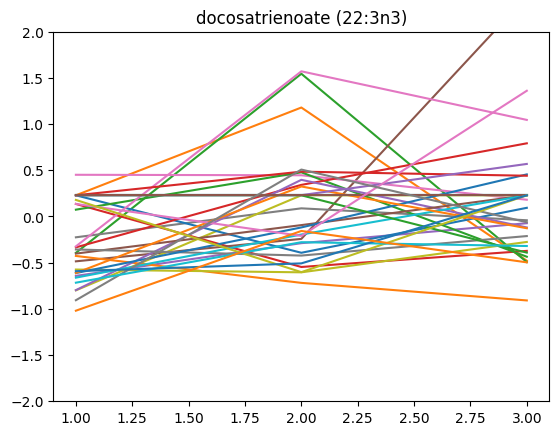

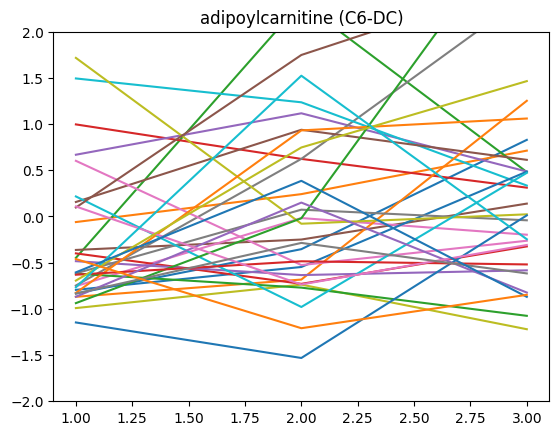

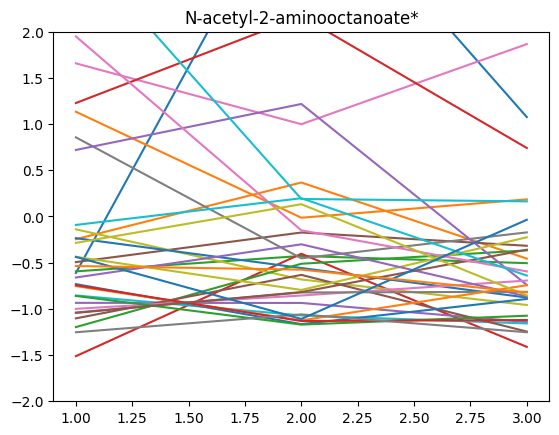

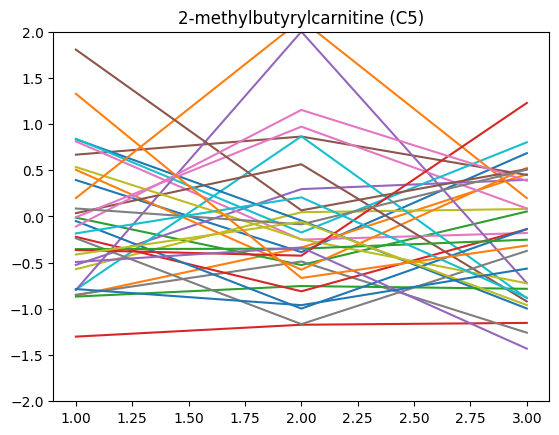

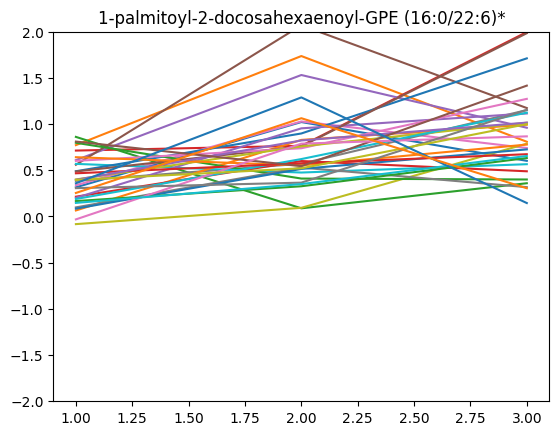

In [115]:
for met in importances_mrmr.keys():
    for p, inds in trimester_plt:

        y = [trimester_df.loc[inds[0]][met], trimester_df.loc[inds[1]][met], trimester_df.loc[inds[2]][met]]
        pe = trimester_df.loc[inds[0]].pe
        if(pe == 0):
            plt.plot([1, 2, 3], y)
    plt.ylim(-2, 2)
    [name] = comp_df[comp_df.COMP_ID == met].BIOCHEMICAL
    plt.title(name)
    plt.show()